# Car Accident Severity by Age Group, and Car Insurance Implications

##### Coursera IBM Data Science Capstone Course

###### by Jamie Boschan

## 1. Introduction and Business Problem
Historically, car insurance companies have charged higher premiums to young and senior drivers, and to men, based on their statistically higher propensity to get into crashes. In order to continue to accurately underwrite car insurance policies, insurance companies need to know if it is still true that age and gender affect the likelihood of a driver getting into crashes that injure or kill people. In this project, I will analyze annual vehicle crash data from Philadelphia, PA in 2018 to see if the historical patterns still hold, and therefore, current underwriting practices are still appropriate. My hypothesis is that it is still true that younger drivers (under 25), older drivers (over 75), and male drivers get into more crashes that cause injuries or deaths.

## 2. Data Understanding and Data Preparation
PennDOT, the Pennsylvania Department of Transportation, collects vehicle crash data from every county in Pennsylvania every year. This crash data is published, shared with the national Department of Transporation, and can be used by the state and local governments to make new laws to improve safety or by car insurance companies to revise their underwriting tables for insurance. In this report, I will focus on vehicle crash data from Philadelphia County, in the year 2018. The data was downloaded from the PennDot Crash Download Map (https://pennshare.maps.arcgis.com/apps/webappviewer/index.html?id=8fdbf046e36e41649bbfd9d7dd7c7e7e), then uploaded into IBM Cloud Storage for this project.

The PennDot download contained eight (8) .csv files for different tables:

* COMMVEH_2018_Philadelphia.csv
* CRASH_2018_Philadelphia.csv
* CYCLE_2018_Philadelphia.csv
* FLAG_2018_Philadelphia.csv
* PERSON_2018_Philadelpia.csv
* ROADWAY_2018_Philadelphia.csv
* TRAILVEH_2018_Philadelphia.csv
* VEHICLE_2018_Philadelphia.csv

These files break up the data into different tables, using a CRN column (Crash Record Number) to link them. The full data dictionary for the PA crash data can be found here: http://pennshare.maps.arcgis.com/sharing/rest/content/items/ffe20c6c3c594389b275c6772a281bcd/data

For this project, I will join the PERSON, CRASH, and FLAG tables using the CRN column as the index because each of these tables has relevant columns.

In [1]:
# Import basic data packages
import pandas as pd
import numpy as np
import types
from botocore.client import Config
import ibm_boto3

In [2]:
# Install seaborn
%%capture
! pip install seaborn

UsageError: Line magic function `%%capture` not found.


In [3]:
# Import visualization packages
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns
from seaborn import pairplot
from statsmodels.graphics.correlation import plot_corr
%matplotlib inline 

In [4]:
# Import modeling & statistics packages
from sklearn.model_selection import train_test_split
import itertools
from sklearn import preprocessing
import pylab as pl
import scipy.optimize as opt
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as sm

In [5]:
# Import evaluation packages
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import log_loss

In [6]:
# The code was removed by Watson Studio for sharing.

,CRN,DISTRICT,COUNTY,MUNICIPALITY,POLICE_AGCY,CRASH_YEAR,CRASH_MONTH,DAY_OF_WEEK,TIME_OF_DAY,HOUR_OF_DAY,...,PED_DEATH_COUNT,PED_MAJ_INJ_COUNT,MAX_SEVERITY_LEVEL,COMM_VEH_COUNT,DEC_LAT,DEC_LONG,RDWY_SURF_TYPE_CD,COUNTY_NAME,MUNICIPALITY_NAME,COUNTY_YEAR
0,2018001306,6,67,67301,67505,2018,1,3,953,9,...,0,0,4,0,39.9857,-75.1519,NaN,Philadelphia,Philadelphia City,CRASH_2018_Philadelphia
1,2018006142,6,67,67301,68K01,2018,1,5,934,9,...,0,0,3,0,39.9946,-75.0841,NaN,Philadelphia,Philadelphia City,CRASH_2018_Philadelphia
2,2018004176,6,67,67301,68K01,2018,1,1,1734,17,...,0,0,0,0,40.0402,-75.0058,NaN,Philadelphia,Philadelphia City,CRASH_2018_Philadelphia
3,2018005229,6,67,67301,68K01,2018,1,2,358,3,...,0,0,0,0,39.9599,-75.1793,NaN,Philadelphia,Philadelphia City,CRASH_2018_Philadelphia
4,2018002147,6,67,67301,67505,2018,1,5,2151,21,...,0,0,0,0,39.9805,-75.1600,NaN,Philadelphia,Philadelphia City,CRASH_2018_Philadelphia


In [7]:
# Read in PERSON_2018_Philadelphia.csv file, stored in this project

body = client_a957345b21d4495a91e605e16dda7be0.get_object(Bucket='courseraibmdatasciencecapstonecou-donotdelete-pr-kbm5mbkattqo7r',Key='PERSON_2018_Philadelphia.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_person = pd.read_csv(body)
df_data_person.head()


,CRN,UNIT_NUM,PERSON_NUM,PERSON_TYPE,INJ_SEVERITY,RESTRAINT_HELMET,AIRBAG_PADS,SEAT_POSITION,EJECTION_IND,AGE,...,PED_LOCATION,PED_SIGNAL,CLOTHING_TYPE,CRASH_YEAR,COUNTY,DISTRICT,MUNICIPALITY,DISTRICT_NAME,COUNTY_NAME,MUNICIPALITY_NAME
0,2018011066,3,3,1.0,0,3.0,10.0,1.0,1.0,33,...,NaN,NaN,NaN,2018,67,6,67301,District 6-0,Philadelphia,Philadelphia City
1,2018011185,1,1,1.0,8,3.0,4.0,1.0,1.0,20,...,NaN,NaN,NaN,2018,67,6,67301,District 6-0,Philadelphia,Philadelphia City
2,2018008009,1,1,1.0,0,3.0,10.0,1.0,1.0,63,...,NaN,NaN,NaN,2018,67,6,67301,District 6-0,Philadelphia,Philadelphia City
3,2018004112,1,1,1.0,0,3.0,1.0,1.0,1.0,21,...,NaN,NaN,NaN,2018,67,6,67301,District 6-0,Philadelphia,Philadelphia City
4,2018002537,1,1,1.0,3,0.0,4.0,1.0,0.0,30,...,NaN,NaN,NaN,2018,67,6,67301,District 6-0,Philadelphia,Philadelphia City


In [8]:
# Read in FLAG_2018_Philadelphia.csv file, stored in this project

body = client_a957345b21d4495a91e605e16dda7be0.get_object(Bucket='courseraibmdatasciencecapstonecou-donotdelete-pr-kbm5mbkattqo7r',Key='FLAG_2018_Philadelphia.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_flag = pd.read_csv(body)
df_data_flag.head()


,CRN,INTERSTATE,STATE_ROAD,LOCAL_ROAD_ONLY,TURNPIKE,WET_ROAD,SNOW_SLUSH_ROAD,ICY_ROAD,SUDDEN_DEER,SHLDR_RELATED,...,CORE_NETWORK,OPIOID_RELATED,LANE_DEPARTURE,SINGLE_VEHICLE,MULTIPLE_VEHICLE,OTHER_FREEWAY_EXPRESSWAY,BACKUP_PRIOR,BACKUP_NONRECURRING,BACKUP_CONGESTION,COUNTY_YEAR
0,2018004109,Yes,Yes,No,No,No,No,No,No,No,...,Yes,No,Yes,No,Yes,No,No,No,No,FLAG_2018_Philadelphia
1,2018007762,Yes,Yes,No,No,No,No,No,No,No,...,Yes,No,No,No,Yes,No,No,No,No,FLAG_2018_Philadelphia
2,2018008701,Yes,Yes,No,No,Yes,No,No,No,No,...,Yes,No,No,No,Yes,No,No,No,No,FLAG_2018_Philadelphia
3,2018004113,Yes,Yes,No,No,No,No,No,No,No,...,Yes,No,No,No,Yes,No,No,No,No,FLAG_2018_Philadelphia
4,2018008009,Yes,Yes,No,No,No,No,No,No,No,...,Yes,No,No,No,Yes,No,No,No,No,FLAG_2018_Philadelphia


In [9]:
# view shape of CRASHES dataframe
df_data_crashes.shape

(11003, 91)

In [10]:
# view shape of PERSON dataframe
df_data_person.shape

(27754, 26)

In [11]:
# view shape of FLAG dataframe
df_data_flag.shape

(11003, 111)

In [12]:
# Since the focus is on drivers, drop all rows from the PERSON dataframe that are not drivers
person = df_data_person[df_data_person.PERSON_TYPE == 1]
person.head()

,CRN,UNIT_NUM,PERSON_NUM,PERSON_TYPE,INJ_SEVERITY,RESTRAINT_HELMET,AIRBAG_PADS,SEAT_POSITION,EJECTION_IND,AGE,...,PED_LOCATION,PED_SIGNAL,CLOTHING_TYPE,CRASH_YEAR,COUNTY,DISTRICT,MUNICIPALITY,DISTRICT_NAME,COUNTY_NAME,MUNICIPALITY_NAME
0,2018011066,3,3,1.0,0,3.0,10.0,1.0,1.0,33,...,NaN,NaN,NaN,2018,67,6,67301,District 6-0,Philadelphia,Philadelphia City
1,2018011185,1,1,1.0,8,3.0,4.0,1.0,1.0,20,...,NaN,NaN,NaN,2018,67,6,67301,District 6-0,Philadelphia,Philadelphia City
2,2018008009,1,1,1.0,0,3.0,10.0,1.0,1.0,63,...,NaN,NaN,NaN,2018,67,6,67301,District 6-0,Philadelphia,Philadelphia City
3,2018004112,1,1,1.0,0,3.0,1.0,1.0,1.0,21,...,NaN,NaN,NaN,2018,67,6,67301,District 6-0,Philadelphia,Philadelphia City
4,2018002537,1,1,1.0,3,0.0,4.0,1.0,0.0,30,...,NaN,NaN,NaN,2018,67,6,67301,District 6-0,Philadelphia,Philadelphia City


In [13]:
# extract potentially relevant columns from PERSON dataframe
person = person[['CRN','PERSON_TYPE','INJ_SEVERITY','AGE','SEX']]
person.head()

,CRN,PERSON_TYPE,INJ_SEVERITY,AGE,SEX
0,2018011066,1.0,0,33,F
1,2018011185,1.0,8,20,M
2,2018008009,1.0,0,63,M
3,2018004112,1.0,0,21,M
4,2018002537,1.0,3,30,M


In [14]:
# extract potentially relevant columns from FLAG dataframe
flag = df_data_flag[['CRN','PROPERTY_DAMAGE_ONLY','INJURY_OR_FATAL','INJURY','FATAL','ALCOHOL_RELATED','DRINKING_DRIVER','UNDERAGE_DRNK_DRV','CELL_PHONE','SPEEDING','SPEEDING_RELATED','AGGRESSIVE_DRIVING','DRIVER_YES6YR','DRIVER_17YR','DRIVER_18YR','DRIVER_19YR','DRIVER_20YR','DRIVER_5NO_64YR','DRIVER_65_74YR','DRIVER_75PLUS']]
flag.head()

,CRN,PROPERTY_DAMAGE_ONLY,INJURY_OR_FATAL,INJURY,FATAL,ALCOHOL_RELATED,DRINKING_DRIVER,UNDERAGE_DRNK_DRV,CELL_PHONE,SPEEDING,SPEEDING_RELATED,AGGRESSIVE_DRIVING,DRIVER_YES6YR,DRIVER_17YR,DRIVER_18YR,DRIVER_19YR,DRIVER_20YR,DRIVER_5NO_64YR,DRIVER_65_74YR,DRIVER_75PLUS
0,2018004109,No,Yes,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No
1,2018007762,Yes,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,Yes,No,No,No
2,2018008701,Yes,No,No,No,No,No,No,No,No,Yes,Yes,No,No,No,No,No,Yes,No,No
3,2018004113,No,Yes,Yes,No,No,No,No,No,No,Yes,Yes,No,No,No,No,No,Yes,No,No
4,2018008009,No,Yes,Yes,No,No,No,No,No,No,No,Yes,No,No,No,No,No,Yes,No,No


In [15]:
# extract potentially relevant columns from CRASH dataframe
crashes = df_data_crashes[['CRN','COLLISION_TYPE','FATAL_COUNT','INJURY_COUNT','DRIVER_COUNT_16YR','DRIVER_COUNT_17YR','DRIVER_COUNT_18YR','DRIVER_COUNT_19YR','DRIVER_COUNT_20YR','DRIVER_COUNT_50_64YR','DRIVER_COUNT_65_74YR','DRIVER_COUNT_75PLUS','MAX_SEVERITY_LEVEL']]
crashes.head()

,CRN,COLLISION_TYPE,FATAL_COUNT,INJURY_COUNT,DRIVER_COUNT_16YR,DRIVER_COUNT_17YR,DRIVER_COUNT_18YR,DRIVER_COUNT_19YR,DRIVER_COUNT_20YR,DRIVER_COUNT_50_64YR,DRIVER_COUNT_65_74YR,DRIVER_COUNT_75PLUS,MAX_SEVERITY_LEVEL
0,2018001306,3,0,1,0,0,0,0,0,1,0,0,4
1,2018006142,1,0,1,0,0,0,0,0,0,0,0,3
2,2018004176,7,0,0,0,0,0,0,0,1,0,0,0
3,2018005229,7,0,0,0,0,0,0,0,0,0,0,0
4,2018002147,7,0,0,0,0,1,0,0,0,0,0,0


In [16]:
# create new dataframe, merging selected columns from FLAG table to PERSON table
df = person.set_index('CRN').join(flag.set_index('CRN'))
df.head()

,PERSON_TYPE,INJ_SEVERITY,AGE,SEX,PROPERTY_DAMAGE_ONLY,INJURY_OR_FATAL,INJURY,FATAL,ALCOHOL_RELATED,DRINKING_DRIVER,...,SPEEDING_RELATED,AGGRESSIVE_DRIVING,DRIVER_YES6YR,DRIVER_17YR,DRIVER_18YR,DRIVER_19YR,DRIVER_20YR,DRIVER_5NO_64YR,DRIVER_65_74YR,DRIVER_75PLUS
CRN,,,,,,,,,,,,,,,,,,,,,
2018000618,1.0,4,39,M,No,Yes,Yes,No,No,No,...,No,No,No,No,No,No,No,No,No,No
2018001306,1.0,0,55,M,No,Yes,Yes,No,No,No,...,No,No,No,No,No,No,No,Yes,No,No
2018001756,1.0,0,17,M,No,Yes,Yes,No,No,No,...,Yes,Yes,No,Yes,No,No,No,No,No,No
2018002147,1.0,0,18,M,Yes,No,No,No,No,No,...,No,Yes,No,No,Yes,No,No,No,No,No
2018002537,1.0,3,30,M,No,Yes,Yes,No,No,No,...,No,No,No,No,No,No,No,No,No,No


In [17]:
# merge selected columns from CRASHES table dataframe containing PERSON and FLAG data
df = df.join(crashes.set_index('CRN'))
df.head()

,PERSON_TYPE,INJ_SEVERITY,AGE,SEX,PROPERTY_DAMAGE_ONLY,INJURY_OR_FATAL,INJURY,FATAL,ALCOHOL_RELATED,DRINKING_DRIVER,...,INJURY_COUNT,DRIVER_COUNT_16YR,DRIVER_COUNT_17YR,DRIVER_COUNT_18YR,DRIVER_COUNT_19YR,DRIVER_COUNT_20YR,DRIVER_COUNT_50_64YR,DRIVER_COUNT_65_74YR,DRIVER_COUNT_75PLUS,MAX_SEVERITY_LEVEL
CRN,,,,,,,,,,,,,,,,,,,,,
2018000618,1.0,4,39,M,No,Yes,Yes,No,No,No,...,1,0,0,0,0,0,0,0,0,4
2018001306,1.0,0,55,M,No,Yes,Yes,No,No,No,...,1,0,0,0,0,0,1,0,0,4
2018001756,1.0,0,17,M,No,Yes,Yes,No,No,No,...,1,0,1,0,0,0,0,0,0,3
2018002147,1.0,0,18,M,Yes,No,No,No,No,No,...,0,0,0,1,0,0,0,0,0,0
2018002537,1.0,3,30,M,No,Yes,Yes,No,No,No,...,2,0,0,0,0,0,0,0,0,3


In [18]:
# view shape of resulting dataframe
df.shape

(19054, 35)

In [19]:
# replace missing values
df.replace("?", np.nan, inplace = True)

In [20]:
missing_data = df.isnull()

In [21]:
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("") 

PERSON_TYPE
False    19054
Name: PERSON_TYPE, dtype: int64

INJ_SEVERITY
False    19054
Name: INJ_SEVERITY, dtype: int64

AGE
False    19054
Name: AGE, dtype: int64

SEX
False    19015
True        39
Name: SEX, dtype: int64

PROPERTY_DAMAGE_ONLY
False    19054
Name: PROPERTY_DAMAGE_ONLY, dtype: int64

INJURY_OR_FATAL
False    19054
Name: INJURY_OR_FATAL, dtype: int64

INJURY
False    19054
Name: INJURY, dtype: int64

FATAL
False    19054
Name: FATAL, dtype: int64

ALCOHOL_RELATED
False    19054
Name: ALCOHOL_RELATED, dtype: int64

DRINKING_DRIVER
False    19054
Name: DRINKING_DRIVER, dtype: int64

UNDERAGE_DRNK_DRV
False    19054
Name: UNDERAGE_DRNK_DRV, dtype: int64

CELL_PHONE
False    19054
Name: CELL_PHONE, dtype: int64

SPEEDING
False    19054
Name: SPEEDING, dtype: int64

SPEEDING_RELATED
False    19054
Name: SPEEDING_RELATED, dtype: int64

AGGRESSIVE_DRIVING
False    19054
Name: AGGRESSIVE_DRIVING, dtype: int64

DRIVER_YES6YR
False    19054
Name: DRIVER_YES6YR, dtype: int64

DRI

In [22]:
df.dtypes

PERSON_TYPE             float64
INJ_SEVERITY              int64
AGE                       int64
SEX                      object
PROPERTY_DAMAGE_ONLY     object
INJURY_OR_FATAL          object
INJURY                   object
FATAL                    object
ALCOHOL_RELATED          object
DRINKING_DRIVER          object
UNDERAGE_DRNK_DRV        object
CELL_PHONE               object
SPEEDING                 object
SPEEDING_RELATED         object
AGGRESSIVE_DRIVING       object
DRIVER_YES6YR            object
DRIVER_17YR              object
DRIVER_18YR              object
DRIVER_19YR              object
DRIVER_20YR              object
DRIVER_5NO_64YR          object
DRIVER_65_74YR           object
DRIVER_75PLUS            object
COLLISION_TYPE            int64
FATAL_COUNT               int64
INJURY_COUNT              int64
DRIVER_COUNT_16YR         int64
DRIVER_COUNT_17YR         int64
DRIVER_COUNT_18YR         int64
DRIVER_COUNT_19YR         int64
DRIVER_COUNT_20YR         int64
DRIVER_C

In [23]:
# convert binary string-typed variables to dummy variables
df.PROPERTY_DAMAGE_ONLY.replace(('Yes', 'No'), (1, 0), inplace=True)
df.INJURY_OR_FATAL.replace(('Yes', 'No'), (1, 0), inplace=True)
df.INJURY.replace(('Yes', 'No'), (1, 0), inplace=True)
df.FATAL.replace(('Yes', 'No'), (1, 0), inplace=True)
df.ALCOHOL_RELATED.replace(('Yes', 'No'), (1, 0), inplace=True)
df.DRINKING_DRIVER.replace(('Yes', 'No'), (1, 0), inplace=True)
df.UNDERAGE_DRNK_DRV.replace(('Yes', 'No'), (1, 0), inplace=True)
df.CELL_PHONE.replace(('Yes', 'No'), (1, 0), inplace=True)
df.SPEEDING.replace(('Yes', 'No'), (1, 0), inplace=True)
df.SPEEDING_RELATED.replace(('Yes', 'No'), (1, 0), inplace=True)
df.AGGRESSIVE_DRIVING.replace(('Yes', 'No'), (1, 0), inplace=True)
df.DRIVER_YES6YR.replace(('Yes', 'No'), (1, 0), inplace=True)
df.DRIVER_17YR.replace(('Yes', 'No'), (1, 0), inplace=True)
df.DRIVER_18YR.replace(('Yes', 'No'), (1, 0), inplace=True)
df.DRIVER_19YR.replace(('Yes', 'No'), (1, 0), inplace=True)
df.DRIVER_20YR.replace(('Yes', 'No'), (1, 0), inplace=True)
df.DRIVER_5NO_64YR.replace(('Yes', 'No'), (1, 0), inplace=True)
df.DRIVER_65_74YR.replace(('Yes', 'No'), (1, 0), inplace=True)
df.DRIVER_75PLUS.replace(('Yes', 'No'), (1, 0), inplace=True)
df.head()

,PERSON_TYPE,INJ_SEVERITY,AGE,SEX,PROPERTY_DAMAGE_ONLY,INJURY_OR_FATAL,INJURY,FATAL,ALCOHOL_RELATED,DRINKING_DRIVER,...,INJURY_COUNT,DRIVER_COUNT_16YR,DRIVER_COUNT_17YR,DRIVER_COUNT_18YR,DRIVER_COUNT_19YR,DRIVER_COUNT_20YR,DRIVER_COUNT_50_64YR,DRIVER_COUNT_65_74YR,DRIVER_COUNT_75PLUS,MAX_SEVERITY_LEVEL
CRN,,,,,,,,,,,,,,,,,,,,,
2018000618,1.0,4,39,M,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,4
2018001306,1.0,0,55,M,0,1,1,0,0,0,...,1,0,0,0,0,0,1,0,0,4
2018001756,1.0,0,17,M,0,1,1,0,0,0,...,1,0,1,0,0,0,0,0,0,3
2018002147,1.0,0,18,M,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2018002537,1.0,3,30,M,0,1,1,0,0,0,...,2,0,0,0,0,0,0,0,0,3


In [24]:
# Convert SEX to a numeric, rather than string variable
df.SEX.replace(('M','F','U'),(0,1,2), inplace=True)
df.head()

,PERSON_TYPE,INJ_SEVERITY,AGE,SEX,PROPERTY_DAMAGE_ONLY,INJURY_OR_FATAL,INJURY,FATAL,ALCOHOL_RELATED,DRINKING_DRIVER,...,INJURY_COUNT,DRIVER_COUNT_16YR,DRIVER_COUNT_17YR,DRIVER_COUNT_18YR,DRIVER_COUNT_19YR,DRIVER_COUNT_20YR,DRIVER_COUNT_50_64YR,DRIVER_COUNT_65_74YR,DRIVER_COUNT_75PLUS,MAX_SEVERITY_LEVEL
CRN,,,,,,,,,,,,,,,,,,,,,
2018000618,1.0,4,39,0.0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,4
2018001306,1.0,0,55,0.0,0,1,1,0,0,0,...,1,0,0,0,0,0,1,0,0,4
2018001756,1.0,0,17,0.0,0,1,1,0,0,0,...,1,0,1,0,0,0,0,0,0,3
2018002147,1.0,0,18,0.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2018002537,1.0,3,30,0.0,0,1,1,0,0,0,...,2,0,0,0,0,0,0,0,0,3


In [25]:
df.shape

(19054, 35)

In [26]:
df = df.astype({'PERSON_TYPE': 'int64'})
df.dtypes

PERSON_TYPE               int64
INJ_SEVERITY              int64
AGE                       int64
SEX                     float64
PROPERTY_DAMAGE_ONLY      int64
INJURY_OR_FATAL           int64
INJURY                    int64
FATAL                     int64
ALCOHOL_RELATED           int64
DRINKING_DRIVER           int64
UNDERAGE_DRNK_DRV         int64
CELL_PHONE                int64
SPEEDING                  int64
SPEEDING_RELATED          int64
AGGRESSIVE_DRIVING        int64
DRIVER_YES6YR             int64
DRIVER_17YR               int64
DRIVER_18YR               int64
DRIVER_19YR               int64
DRIVER_20YR               int64
DRIVER_5NO_64YR           int64
DRIVER_65_74YR            int64
DRIVER_75PLUS             int64
COLLISION_TYPE            int64
FATAL_COUNT               int64
INJURY_COUNT              int64
DRIVER_COUNT_16YR         int64
DRIVER_COUNT_17YR         int64
DRIVER_COUNT_18YR         int64
DRIVER_COUNT_19YR         int64
DRIVER_COUNT_20YR         int64
DRIVER_C

In [27]:
df.head()

,PERSON_TYPE,INJ_SEVERITY,AGE,SEX,PROPERTY_DAMAGE_ONLY,INJURY_OR_FATAL,INJURY,FATAL,ALCOHOL_RELATED,DRINKING_DRIVER,...,INJURY_COUNT,DRIVER_COUNT_16YR,DRIVER_COUNT_17YR,DRIVER_COUNT_18YR,DRIVER_COUNT_19YR,DRIVER_COUNT_20YR,DRIVER_COUNT_50_64YR,DRIVER_COUNT_65_74YR,DRIVER_COUNT_75PLUS,MAX_SEVERITY_LEVEL
CRN,,,,,,,,,,,,,,,,,,,,,
2018000618,1,4,39,0.0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,4
2018001306,1,0,55,0.0,0,1,1,0,0,0,...,1,0,0,0,0,0,1,0,0,4
2018001756,1,0,17,0.0,0,1,1,0,0,0,...,1,0,1,0,0,0,0,0,0,3
2018002147,1,0,18,0.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2018002537,1,3,30,0.0,0,1,1,0,0,0,...,2,0,0,0,0,0,0,0,0,3


In [28]:
# compute variables Severity_Desc and Severity_Code

# conditions
conditions_text = [
    (df['INJURY_OR_FATAL'] == 1),
    (df['INJURY_OR_FATAL'] == 0) & (df['PROPERTY_DAMAGE_ONLY'] == 1)]

# create a list of the values we want to assign for each condition
values_text = ['INJURY COLLISION', 'PROPERTY DAMAGE ONLY COLLISION']

# create a new column and use np.select to assign values to it using our lists as arguments
df['SEVERITY_DESC'] = np.select(conditions_text, values_text)

conditions_num = [
    (df['INJURY_OR_FATAL'] == 1),
    (df['INJURY_OR_FATAL'] == 0) & (df['PROPERTY_DAMAGE_ONLY'] == 1)]

# create a list of the values we want to assign for each condition
values_num = [1, 2]

df['SEVERITY_CODE'] = np.select(conditions_num, values_num)

# display updated DataFrame
df.head()

,PERSON_TYPE,INJ_SEVERITY,AGE,SEX,PROPERTY_DAMAGE_ONLY,INJURY_OR_FATAL,INJURY,FATAL,ALCOHOL_RELATED,DRINKING_DRIVER,...,DRIVER_COUNT_17YR,DRIVER_COUNT_18YR,DRIVER_COUNT_19YR,DRIVER_COUNT_20YR,DRIVER_COUNT_50_64YR,DRIVER_COUNT_65_74YR,DRIVER_COUNT_75PLUS,MAX_SEVERITY_LEVEL,SEVERITY_DESC,SEVERITY_CODE
CRN,,,,,,,,,,,,,,,,,,,,,
2018000618,1,4,39,0.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,4,INJURY COLLISION,1
2018001306,1,0,55,0.0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,4,INJURY COLLISION,1
2018001756,1,0,17,0.0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,3,INJURY COLLISION,1
2018002147,1,0,18,0.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,PROPERTY DAMAGE ONLY COLLISION,2
2018002537,1,3,30,0.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,3,INJURY COLLISION,1


In [29]:
# clean up column names that imported strangely
df.rename(columns={"DRIVER_YES6YR": "DRIVER_16YR", "DRIVER_5NO_64YR": "DRIVER_50_64YR"}, inplace=True)
df.head()

,PERSON_TYPE,INJ_SEVERITY,AGE,SEX,PROPERTY_DAMAGE_ONLY,INJURY_OR_FATAL,INJURY,FATAL,ALCOHOL_RELATED,DRINKING_DRIVER,...,DRIVER_COUNT_17YR,DRIVER_COUNT_18YR,DRIVER_COUNT_19YR,DRIVER_COUNT_20YR,DRIVER_COUNT_50_64YR,DRIVER_COUNT_65_74YR,DRIVER_COUNT_75PLUS,MAX_SEVERITY_LEVEL,SEVERITY_DESC,SEVERITY_CODE
CRN,,,,,,,,,,,,,,,,,,,,,
2018000618,1,4,39,0.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,4,INJURY COLLISION,1
2018001306,1,0,55,0.0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,4,INJURY COLLISION,1
2018001756,1,0,17,0.0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,3,INJURY COLLISION,1
2018002147,1,0,18,0.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,PROPERTY DAMAGE ONLY COLLISION,2
2018002537,1,3,30,0.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,3,INJURY COLLISION,1


In [30]:
# simply drop whole row with NaN in "Sex" column
df.dropna(subset=["SEX"], axis=0, inplace=True)
df.head()

,PERSON_TYPE,INJ_SEVERITY,AGE,SEX,PROPERTY_DAMAGE_ONLY,INJURY_OR_FATAL,INJURY,FATAL,ALCOHOL_RELATED,DRINKING_DRIVER,...,DRIVER_COUNT_17YR,DRIVER_COUNT_18YR,DRIVER_COUNT_19YR,DRIVER_COUNT_20YR,DRIVER_COUNT_50_64YR,DRIVER_COUNT_65_74YR,DRIVER_COUNT_75PLUS,MAX_SEVERITY_LEVEL,SEVERITY_DESC,SEVERITY_CODE
CRN,,,,,,,,,,,,,,,,,,,,,
2018000618,1,4,39,0.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,4,INJURY COLLISION,1
2018001306,1,0,55,0.0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,4,INJURY COLLISION,1
2018001756,1,0,17,0.0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,3,INJURY COLLISION,1
2018002147,1,0,18,0.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,PROPERTY DAMAGE ONLY COLLISION,2
2018002537,1,3,30,0.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,3,INJURY COLLISION,1


In [31]:
# drop rows where MAX_SEVERITY_LEVEL equals 9, which indicates "possible injury," because this is vague and unhelpful
df.drop(df[df.MAX_SEVERITY_LEVEL == 9].index, inplace=True)
df.shape

(18183, 37)

In [32]:
# drop rows where SEX is "Unknown"
df.drop(df[df.SEX == 2].index, inplace=True)

In [33]:
df.head()

,PERSON_TYPE,INJ_SEVERITY,AGE,SEX,PROPERTY_DAMAGE_ONLY,INJURY_OR_FATAL,INJURY,FATAL,ALCOHOL_RELATED,DRINKING_DRIVER,...,DRIVER_COUNT_17YR,DRIVER_COUNT_18YR,DRIVER_COUNT_19YR,DRIVER_COUNT_20YR,DRIVER_COUNT_50_64YR,DRIVER_COUNT_65_74YR,DRIVER_COUNT_75PLUS,MAX_SEVERITY_LEVEL,SEVERITY_DESC,SEVERITY_CODE
CRN,,,,,,,,,,,,,,,,,,,,,
2018000618,1,4,39,0.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,4,INJURY COLLISION,1
2018001306,1,0,55,0.0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,4,INJURY COLLISION,1
2018001756,1,0,17,0.0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,3,INJURY COLLISION,1
2018002147,1,0,18,0.0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,PROPERTY DAMAGE ONLY COLLISION,2
2018002537,1,3,30,0.0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,3,INJURY COLLISION,1


In [34]:
# Create simplified severity level variable
# conditions
conditions_severity = [
    (df['MAX_SEVERITY_LEVEL'] == 0),
    (df['MAX_SEVERITY_LEVEL'] >= 2),
    (df['MAX_SEVERITY_LEVEL'] == 1)]

# create a list of the values we want to assign for each condition
values_severity = [0, 1, 2]

# create a new column and use np.select to assign values to it using our lists as arguments
df['SEVERITY_LEVEL'] = np.select(conditions_severity, values_severity)

# display updated DataFrame
df.head()

,PERSON_TYPE,INJ_SEVERITY,AGE,SEX,PROPERTY_DAMAGE_ONLY,INJURY_OR_FATAL,INJURY,FATAL,ALCOHOL_RELATED,DRINKING_DRIVER,...,DRIVER_COUNT_18YR,DRIVER_COUNT_19YR,DRIVER_COUNT_20YR,DRIVER_COUNT_50_64YR,DRIVER_COUNT_65_74YR,DRIVER_COUNT_75PLUS,MAX_SEVERITY_LEVEL,SEVERITY_DESC,SEVERITY_CODE,SEVERITY_LEVEL
CRN,,,,,,,,,,,,,,,,,,,,,
2018000618,1,4,39,0.0,0,1,1,0,0,0,...,0,0,0,0,0,0,4,INJURY COLLISION,1,1
2018001306,1,0,55,0.0,0,1,1,0,0,0,...,0,0,0,1,0,0,4,INJURY COLLISION,1,1
2018001756,1,0,17,0.0,0,1,1,0,0,0,...,0,0,0,0,0,0,3,INJURY COLLISION,1,1
2018002147,1,0,18,0.0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,PROPERTY DAMAGE ONLY COLLISION,2,0
2018002537,1,3,30,0.0,0,1,1,0,0,0,...,0,0,0,0,0,0,3,INJURY COLLISION,1,1


### 3. Exploratory Data Analysis & Data Visualization

Since my objective is to classify drivers into risk categories based on age and sex, I will be building one or more categorical models. Before doing that, I want to understand how some of the variables are related so I can have a better idea of which variables to use to build the model. For predictors, I want to focus on Gender (SEX) and Age as predictors of more, or more serious, car crashes. From the dataframe, I could use either the raw Age and Sex variables, the dummy variable flags for driver ages and genders, and/or the grouped age variables as predictors. Similarly, for a target, I could choose MAX_SEVERITY_LEVEL, SEVERITY_CODE, INJURY_OR_FATAL, FATAL or INJURY as the variable I am trying to predict. Below, I will try to gauge relationships between these different variables to hopefully choose the best ones for my model(s).

In [35]:
df.corr()

,PERSON_TYPE,INJ_SEVERITY,AGE,SEX,PROPERTY_DAMAGE_ONLY,INJURY_OR_FATAL,INJURY,FATAL,ALCOHOL_RELATED,DRINKING_DRIVER,...,DRIVER_COUNT_17YR,DRIVER_COUNT_18YR,DRIVER_COUNT_19YR,DRIVER_COUNT_20YR,DRIVER_COUNT_50_64YR,DRIVER_COUNT_65_74YR,DRIVER_COUNT_75PLUS,MAX_SEVERITY_LEVEL,SEVERITY_CODE,SEVERITY_LEVEL
PERSON_TYPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
INJ_SEVERITY,NaN,1.000000,0.065254,0.093286,-0.426513,0.426513,0.428743,-0.009777,0.026536,0.034142,...,-0.014715,-0.009169,-0.017546,-0.017554,-0.000037,-0.005831,0.008356,0.513938,-0.426513,0.411456
AGE,NaN,0.065254,1.000000,-0.067413,-0.089077,0.089077,0.084857,0.022165,-0.010694,-0.014944,...,-0.068262,-0.088331,-0.111547,-0.114574,0.282467,0.245075,0.240848,0.082619,-0.089077,0.090688
SEX,NaN,0.093286,-0.067413,1.000000,-0.041373,0.041373,0.044877,-0.031430,-0.041823,-0.038743,...,0.002572,0.019410,0.006948,0.005074,-0.022549,-0.011860,0.015947,0.035212,-0.041373,0.033923
PROPERTY_DAMAGE_ONLY,NaN,-0.426513,-0.089077,-0.041373,1.000000,-1.000000,-0.987741,-0.057898,-0.001376,0.007065,...,0.015728,0.016378,0.019630,0.029014,-0.024828,0.000041,-0.031846,-0.774156,1.000000,-0.980577
INJURY_OR_FATAL,NaN,0.426513,0.089077,0.041373,-1.000000,1.000000,0.987741,0.057898,0.001376,-0.007065,...,-0.015728,-0.016378,-0.019630,-0.029014,0.024828,-0.000041,0.031846,0.774156,-1.000000,0.980577
INJURY,NaN,0.428743,0.084857,0.044877,-0.987741,0.987741,1.000000,-0.063086,-0.006179,-0.006968,...,-0.016835,-0.014655,-0.017565,-0.026780,0.024757,-0.000188,0.032448,0.779962,-0.987741,0.944926
FATAL,NaN,-0.009777,0.022165,-0.031430,-0.057898,0.057898,-0.063086,1.000000,0.103096,0.057132,...,0.001637,-0.013563,-0.016256,-0.009897,-0.013916,0.020803,0.002921,-0.081932,-0.057898,0.252581
ALCOHOL_RELATED,NaN,0.026536,-0.010694,-0.041823,-0.001376,0.001376,-0.006179,0.103096,1.000000,0.966781,...,-0.015624,-0.006329,-0.014405,-0.013813,-0.016007,-0.019155,-0.015286,-0.008971,-0.001376,0.021588
DRINKING_DRIVER,NaN,0.034142,-0.014944,-0.038743,0.007065,-0.007065,-0.006968,0.057132,0.966781,1.000000,...,-0.014560,-0.004541,-0.012477,-0.011722,-0.012702,-0.019776,-0.018072,-0.010423,0.007065,0.004378


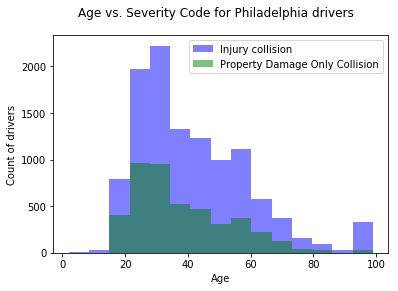

In [36]:
# histogram: Severity Code vs Age
fig, ax = plt.subplots()

ax.hist(df[df["SEVERITY_CODE"]==1]["AGE"], bins=15, alpha=0.5, color="blue", label="Injury collision")
ax.hist(df[df["SEVERITY_CODE"]==2]["AGE"], bins=15, alpha=0.5, color="green", label="Property Damage Only Collision")

ax.set_xlabel("Age")
ax.set_ylabel("Count of drivers")

fig.suptitle("Age vs. Severity Code for Philadelphia drivers")

ax.legend();

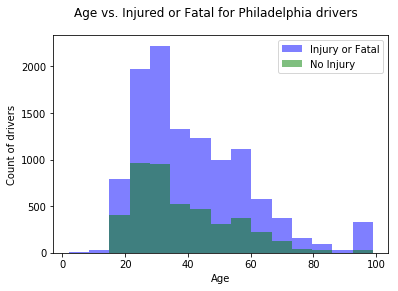

In [37]:
# histogram: Injured_or_fatal vs Age
fig, ax = plt.subplots()

ax.hist(df[df["INJURY_OR_FATAL"]==1]["AGE"], bins=15, alpha=0.5, color="blue", label="Injury or Fatal")
ax.hist(df[df["INJURY_OR_FATAL"]==0]["AGE"], bins=15, alpha=0.5, color="green", label="No Injury")

ax.set_xlabel("Age")
ax.set_ylabel("Count of drivers")

fig.suptitle("Age vs. Injured or Fatal for Philadelphia drivers")

ax.legend();

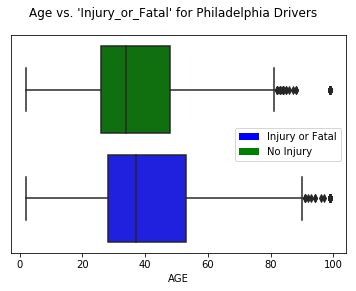

In [38]:
fig, ax = plt.subplots()

sns.boxplot(x="AGE", y="INJURY_OR_FATAL", data=df, orient="h", palette={1:"blue", 0:"green"}, ax=ax)

ax.get_yaxis().set_visible(False)

fig.suptitle("Age vs. 'Injury_or_Fatal' for Philadelphia Drivers")

color_patches = [
    Patch(facecolor="blue", label="Injury or Fatal"),
    Patch(facecolor="green", label="No Injury")
]
ax.legend(handles=color_patches);

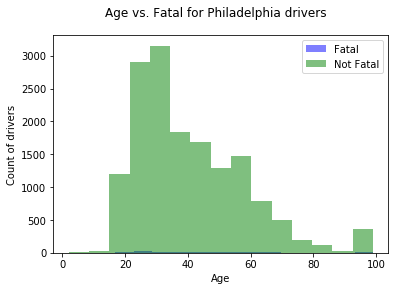

In [39]:
# histogram: Fatal crashes vs Age
fig, ax = plt.subplots()

ax.hist(df[df["FATAL"]==1]["AGE"], bins=15, alpha=0.5, color="blue", label="Fatal")
ax.hist(df[df["FATAL"]==0]["AGE"], bins=15, alpha=0.5, color="green", label="Not Fatal")

ax.set_xlabel("Age")
ax.set_ylabel("Count of drivers")

fig.suptitle("Age vs. Fatal for Philadelphia drivers")

ax.legend();

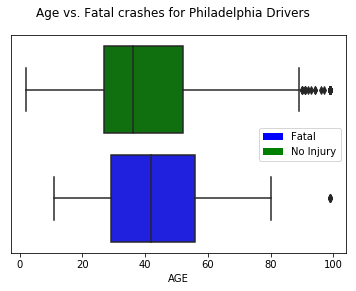

In [40]:
fig, ax = plt.subplots()

sns.boxplot(x="AGE", y="FATAL", data=df, orient="h", palette={1:"blue", 0:"green"}, ax=ax)

ax.get_yaxis().set_visible(False)

fig.suptitle("Age vs. Fatal crashes for Philadelphia Drivers")

color_patches = [
    Patch(facecolor="blue", label="Fatal"),
    Patch(facecolor="green", label="No Injury")
]
ax.legend(handles=color_patches);

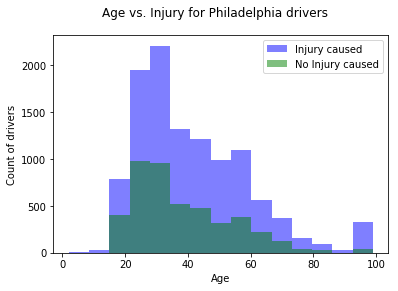

In [41]:
# histogram: Injury crashes vs Age
fig, ax = plt.subplots()

ax.hist(df[df["INJURY"]==1]["AGE"], bins=15, alpha=0.5, color="blue", label="Injury caused")
ax.hist(df[df["INJURY"]==0]["AGE"], bins=15, alpha=0.5, color="green", label="No Injury caused")

ax.set_xlabel("Age")
ax.set_ylabel("Count of drivers")

fig.suptitle("Age vs. Injury for Philadelphia drivers")

ax.legend();

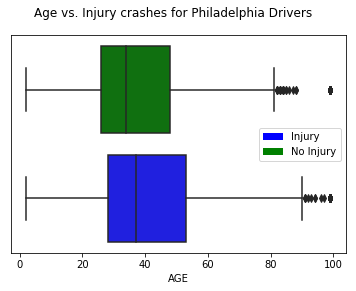

In [42]:
fig, ax = plt.subplots()

sns.boxplot(x="AGE", y="INJURY", data=df, orient="h", palette={1:"blue", 0:"green"}, ax=ax)

ax.get_yaxis().set_visible(False)

fig.suptitle("Age vs. Injury crashes for Philadelphia Drivers")

color_patches = [
    Patch(facecolor="blue", label="Injury"),
    Patch(facecolor="green", label="No Injury")
]
ax.legend(handles=color_patches);

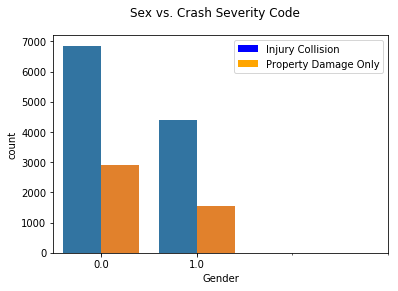

In [43]:
# bar chart: severity code vs. gender
fig, ax = plt.subplots()

sns.catplot("SEX", hue="SEVERITY_CODE", data=df, kind="count", 
             ax=ax)

plt.close(2) # catplot creates an extra figure we don't need

ax.set_xlabel("Gender")
ax.set_xticks(np.arange(4), ('Male', 'Female'))

color_patches = [
    Patch(facecolor="blue", label="Injury Collision"),
    Patch(facecolor="orange", label="Property Damage Only")
]
ax.legend(handles=color_patches)

fig.suptitle("Sex vs. Crash Severity Code");


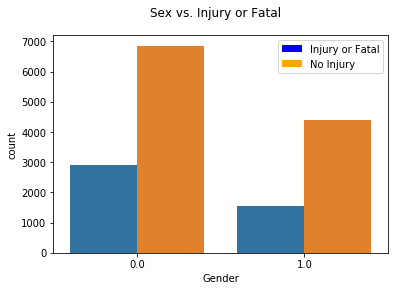

In [44]:
# bar chart: severity code vs. Injury_or_Fatal
fig, ax = plt.subplots()

sns.catplot("SEX", hue="INJURY_OR_FATAL", data=df, kind="count", 
             ax=ax)

plt.close(2) # catplot creates an extra figure we don't need

ax.set_xlabel("Gender")

color_patches = [
    Patch(facecolor="blue", label="Injury or Fatal"),
    Patch(facecolor="orange", label="No Injury")
]
ax.legend(handles=color_patches)

fig.suptitle("Sex vs. Injury or Fatal");


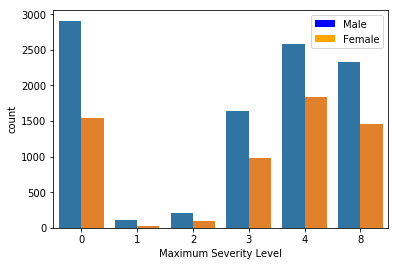

In [45]:
# Sex vs. Maximum severity Level
g, ax = plt.subplots()

sns.catplot("MAX_SEVERITY_LEVEL", hue="SEX", data=df, kind="count", ax=ax)

plt.close(2) # catplot creates an extra figure we don't need

ax.set_xlabel("Maximum Severity Level")

color_patches = [
    Patch(facecolor="blue", label="Male"),
    Patch(facecolor="orange", label="Female")
]
ax.legend(handles=color_patches)

fig.suptitle("Sex vs. Max Severity Level");


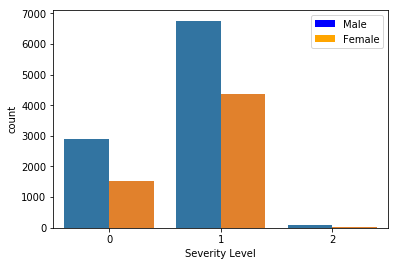

In [46]:
# Sex vs. Severity Level
g, ax = plt.subplots()

sns.catplot("SEVERITY_LEVEL", hue="SEX", data=df, kind="count", ax=ax)

plt.close(2) # catplot creates an extra figure we don't need

ax.set_xlabel("Severity Level")

color_patches = [
    Patch(facecolor="blue", label="Male"),
    Patch(facecolor="orange", label="Female")
]
ax.legend(handles=color_patches)

fig.suptitle("Sex vs. Severity Level");

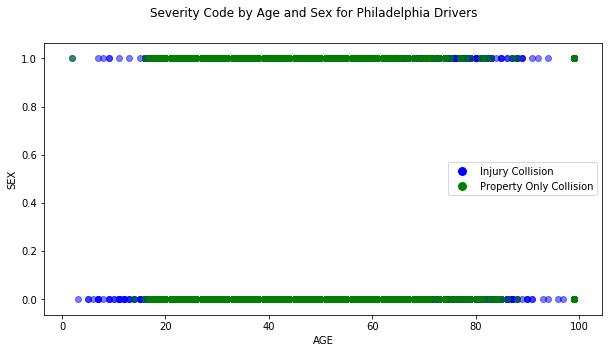

In [47]:
# scatterplot, Sex vs Age vs severity Code
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(df[df["SEVERITY_CODE"]==1]["AGE"], df[df["SEVERITY_CODE"]==1]["SEX"], c="blue", alpha=0.5)
ax.scatter(df[df["SEVERITY_CODE"]==2]["AGE"], df[df["SEVERITY_CODE"]==2]["SEX"], c="green", alpha=0.5)

ax.set_xlabel("AGE")
ax.set_ylabel("SEX")

color_patches = [
    Line2D([0], [0], marker='o', color='w', label='Injury Collision', markerfacecolor='b', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Property Only Collision', markerfacecolor='g', markersize=10)
]
ax.legend(handles=color_patches)

fig.suptitle("Severity Code by Age and Sex for Philadelphia Drivers");

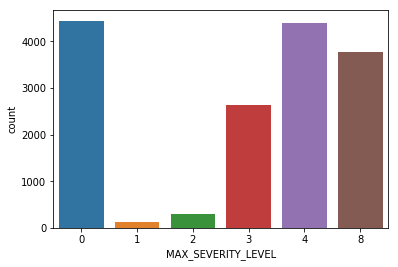

In [48]:
ax = sns.countplot(x="MAX_SEVERITY_LEVEL", data=df)

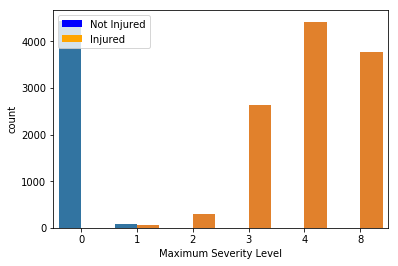

In [49]:
# Injury vs. Maximum severity Level
g, ax = plt.subplots()

sns.catplot("MAX_SEVERITY_LEVEL", hue="INJURY", data=df, kind="count", ax=ax)

plt.close(2) # catplot creates an extra figure we don't need

ax.set_xlabel("Maximum Severity Level")

color_patches = [
    Patch(facecolor="blue", label="Not Injured"),
    Patch(facecolor="orange", label="Injured")
]
ax.legend(handles=color_patches)

fig.suptitle("Injury vs. Max Severity Level");

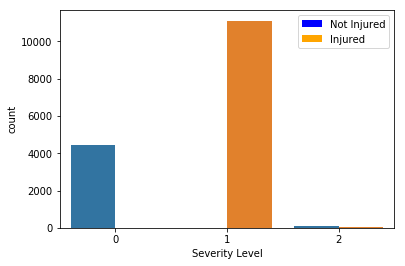

In [50]:
# Injury vs. Severity Level
g, ax = plt.subplots()

sns.catplot("SEVERITY_LEVEL", hue="INJURY", data=df, kind="count", ax=ax)

plt.close(2) # catplot creates an extra figure we don't need

ax.set_xlabel("Severity Level")

color_patches = [
    Patch(facecolor="blue", label="Not Injured"),
    Patch(facecolor="orange", label="Injured")
]
ax.legend(handles=color_patches)

fig.suptitle("Injury vs. Severity Level");

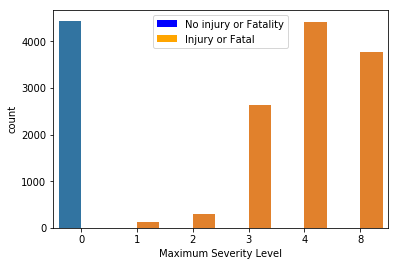

In [51]:
# Injury_or_Fatal vs. Maximum severity Level
g, ax = plt.subplots()

sns.catplot("MAX_SEVERITY_LEVEL", hue="INJURY_OR_FATAL", data=df, kind="count", ax=ax)

plt.close(2) # catplot creates an extra figure we don't need

ax.set_xlabel("Maximum Severity Level")

color_patches = [
    Patch(facecolor="blue", label="No injury or Fatality"),
    Patch(facecolor="orange", label="Injury or Fatal")
]
ax.legend(handles=color_patches)

fig.suptitle("Injury or Fatal vs. Max Severity Level");

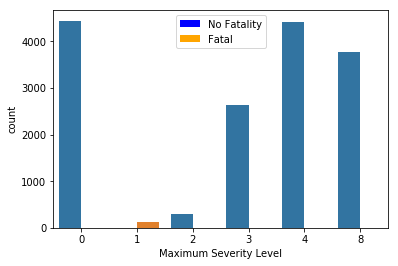

In [52]:
# Fatal vs. Maximum severity Level
g, ax = plt.subplots()

sns.catplot("MAX_SEVERITY_LEVEL", hue="FATAL", data=df, kind="count", ax=ax)

plt.close(2) # catplot creates an extra figure we don't need

ax.set_xlabel("Maximum Severity Level")

color_patches = [
    Patch(facecolor="blue", label="No Fatality"),
    Patch(facecolor="orange", label="Fatal")
]
ax.legend(handles=color_patches)

fig.suptitle("Injury or Fatal vs. Max Severity Level");

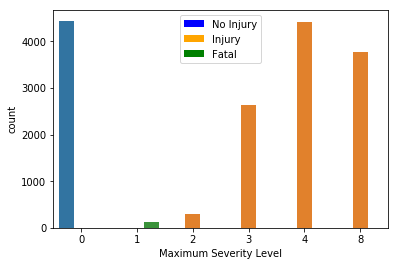

In [53]:
# Severity Level vs. Maximum severity Level
g, ax = plt.subplots()

sns.catplot("MAX_SEVERITY_LEVEL", hue="SEVERITY_LEVEL", data=df, kind="count", ax=ax)

plt.close(2) # catplot creates an extra figure we don't need

ax.set_xlabel("Maximum Severity Level")

color_patches = [
    Patch(facecolor="blue", label="No Injury"),
    Patch(facecolor="orange", label="Injury"),
    Patch(facecolor="green", label="Fatal")
]
ax.legend(handles=color_patches)

fig.suptitle("Severity Level vs. Max Severity Level");

### 4. Modeling & Model Evaluation

The research objective of this project is to see whether &mdash; and to what extent &mdash; age and gender are still relevant factors for Car Insurance companies when calculating insurance prices for drivers. According to Carinsurance.com and thezebra.com, nationally, car insurance rates are highest for 16-year olds but decrease annually until about age 25 before leveling off. They then begin to increase again around age 70. For drivers 25 and younger, male drivers pay more for car insurance than female drivers, but this difference is negligible for older drivers. According to thezebra.com, insurers in Pennsylvania do not use gender as a factor in car insurance premiums. Nevertheless, in most of the country gender and age are both factors considered in the price of car insurance. Therefore, I will build some models using the Philadelphia, PA crash data to try to segment drivers into risk groups, which each can be assigned prices.  

The charts from the exploratory data analysis mostly showed stronger patterns of difference for male vs. female drivers than for age based on the graphs, but the SEVERITY_CODE vs AGE vs SEX chart did show more injuries at the lower and upper age ranges, compared to the middle. I intended to use the "Severity Code" variable as a target, because I created it to match the one in the sample dataset. However, the graphs above do not support the use of this variable because many crashes may not have had any damage or injuries. Then I tried to use MAX_SEVERITY_LEVEL as the target, but this variable had too many categories, so the models were weak. I recoded MAX_SEVERITY_LEVEL into a new variable called SEVERITY_LEVEL with the following categories:

* NO INJURIES
* INJURIES
* FATAL

Again, my objective is to evaluate whether age and gender influence accident severity, as defined by injuries or fatalities, enough to be considered factors by car insurance companies in setting risk/price categories. My objective is not to ultimately identify those insurance risk categories. Therefore, I will utilize logistic regression to predict accident severity. I chose logistic regression because by evaluating the coefficients in the resulting equation, I can assess not only whether the model is accurate but which predictors have the most impact. 

I will create several different Logistic Regression models using different combinations of the variables available in the final dataframe. For each one, I will evaluate both the underlying statistical validity and the model's predictive accuracy.

#### 4. A. Model #1
##### 4. A. 1. Create dataframe

In [54]:
df.columns

Index(['PERSON_TYPE', 'INJ_SEVERITY', 'AGE', 'SEX', 'PROPERTY_DAMAGE_ONLY',
       'INJURY_OR_FATAL', 'INJURY', 'FATAL', 'ALCOHOL_RELATED',
       'DRINKING_DRIVER', 'UNDERAGE_DRNK_DRV', 'CELL_PHONE', 'SPEEDING',
       'SPEEDING_RELATED', 'AGGRESSIVE_DRIVING', 'DRIVER_16YR', 'DRIVER_17YR',
       'DRIVER_18YR', 'DRIVER_19YR', 'DRIVER_20YR', 'DRIVER_50_64YR',
       'DRIVER_65_74YR', 'DRIVER_75PLUS', 'COLLISION_TYPE', 'FATAL_COUNT',
       'INJURY_COUNT', 'DRIVER_COUNT_16YR', 'DRIVER_COUNT_17YR',
       'DRIVER_COUNT_18YR', 'DRIVER_COUNT_19YR', 'DRIVER_COUNT_20YR',
       'DRIVER_COUNT_50_64YR', 'DRIVER_COUNT_65_74YR', 'DRIVER_COUNT_75PLUS',
       'MAX_SEVERITY_LEVEL', 'SEVERITY_DESC', 'SEVERITY_CODE',
       'SEVERITY_LEVEL'],
      dtype='object')

In [55]:
df_r1 = df[['AGE','SEX','ALCOHOL_RELATED','CELL_PHONE','SPEEDING','SPEEDING_RELATED','DRIVER_16YR','DRIVER_17YR','DRIVER_18YR','DRIVER_19YR','DRIVER_20YR','DRIVER_75PLUS','DRIVER_COUNT_16YR','DRIVER_COUNT_17YR','DRIVER_COUNT_18YR','DRIVER_COUNT_19YR','DRIVER_COUNT_20YR','DRIVER_COUNT_50_64YR','DRIVER_COUNT_65_74YR','DRIVER_COUNT_75PLUS','MAX_SEVERITY_LEVEL','SEVERITY_LEVEL']]

In [56]:
df_r1.shape

(15691, 22)

In [57]:
df_r1.head()

,AGE,SEX,ALCOHOL_RELATED,CELL_PHONE,SPEEDING,SPEEDING_RELATED,DRIVER_16YR,DRIVER_17YR,DRIVER_18YR,DRIVER_19YR,...,DRIVER_COUNT_16YR,DRIVER_COUNT_17YR,DRIVER_COUNT_18YR,DRIVER_COUNT_19YR,DRIVER_COUNT_20YR,DRIVER_COUNT_50_64YR,DRIVER_COUNT_65_74YR,DRIVER_COUNT_75PLUS,MAX_SEVERITY_LEVEL,SEVERITY_LEVEL
CRN,,,,,,,,,,,,,,,,,,,,,
2018000618,39,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,1
2018001306,55,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,4,1
2018001756,17,0.0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,3,1
2018002147,18,0.0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2018002537,30,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1


##### 4. A. 2. Define X & y, and split into training & testing sets

In [58]:
X1 = df_r1[['AGE','SEX','ALCOHOL_RELATED','CELL_PHONE','SPEEDING','SPEEDING_RELATED','DRIVER_16YR','DRIVER_17YR','DRIVER_18YR','DRIVER_19YR','DRIVER_20YR','DRIVER_75PLUS','DRIVER_COUNT_16YR','DRIVER_COUNT_17YR','DRIVER_COUNT_18YR','DRIVER_COUNT_19YR','DRIVER_COUNT_20YR','DRIVER_COUNT_50_64YR','DRIVER_COUNT_65_74YR','DRIVER_COUNT_75PLUS']].values

In [59]:
X1[0:5]

array([[39.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [17.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [18.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [60]:
y = df_r1['SEVERITY_LEVEL']
y[0:5]

CRN
2018000618    1
2018001306    1
2018001756    1
2018002147    0
2018002537    1
Name: SEVERITY_LEVEL, dtype: int64

In [61]:
X1_trainset, X1_testset, y_trainset, y_testset = train_test_split(X1, y, test_size=0.3, random_state=3)

In [62]:
print("Size of X1_trainset: ",X1_trainset.shape)
print("Size of y_trainset: ",y_trainset.shape)
print("Size of X_testset: ",X1_testset.shape)
print("Size of y_testset: ",y_testset.shape)

Size of X1_trainset:  (10983, 20)
Size of y_trainset:  (10983,)
Size of X_testset:  (4708, 20)
Size of y_testset:  (4708,)


##### 4. A. 3. Build Model #1 using SKLearn methods

In [63]:
LR1 = LogisticRegression(C=0.01, solver='liblinear', multi_class='auto').fit(X1_trainset,y_trainset)
LR1

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [64]:
yhat_lr1 = LR1.predict(X1_testset)
yhat_lr1

array([1, 1, 1, ..., 1, 1, 1])

In [65]:
yhat_prob1 = LR1.predict_proba(X1_testset)
yhat_prob1

array([[2.95831401e-01, 6.90341403e-01, 1.38271957e-02],
       [2.13982983e-01, 7.85635557e-01, 3.81460263e-04],
       [2.59301386e-01, 7.29173104e-01, 1.15255101e-02],
       ...,
       [1.59673865e-01, 8.40225606e-01, 1.00528956e-04],
       [4.06127957e-01, 5.87361434e-01, 6.51060919e-03],
       [2.82063943e-01, 6.86102434e-01, 3.18336227e-02]])

In [66]:
print('Coefficients: ', LR1.coef_)

Coefficients:  [[-1.47993040e-02 -1.84909383e-01 -1.67011437e-02 -2.64046345e-02
  -2.14822291e-01  5.83360023e-01 -2.24517238e-02  1.42285508e-02
   1.48994937e-02 -1.47028683e-02  4.65915318e-02  1.51205942e-02
  -2.24517238e-02  1.42285508e-02  1.48994937e-02 -1.47028683e-02
   6.72272300e-02  1.50499922e-02  1.10600704e-01  4.49454554e-03]
 [ 1.35785149e-02  2.00261909e-01 -7.70652818e-02  2.87678939e-02
   1.21818918e-01 -5.87526876e-01  2.37620623e-02 -1.37806180e-02
  -7.40550492e-03  2.31508193e-02 -3.94106241e-02 -1.68599738e-02
   2.37620623e-02 -1.37806180e-02 -7.40550492e-03  2.31508193e-02
  -6.01924108e-02 -3.88204171e-04 -1.26970274e-01 -4.28148634e-03]
 [-1.06067444e-01 -3.31373100e-01  1.45636370e-01 -5.69554502e-03
   1.17152370e-01 -7.23619310e-02 -1.24274675e-02 -4.04352850e-02
  -7.74979214e-02 -9.31715513e-02 -9.32196851e-02  2.16562054e-02
  -1.24274675e-02 -4.04352850e-02 -7.74979214e-02 -9.31715513e-02
  -9.78756516e-02 -3.92774011e-02  8.15713481e-02  2.120314

##### 4. A. 4. Build model #1 with StatsModels

In [67]:
# building the model and fitting the data 
log_reg1 = sm.MNLogit(y_trainset, X1_trainset).fit() 

         Current function value: 0.635260
         Iterations: 35


/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [68]:
yhat_lr1sm = log_reg1.predict(X1_testset) 
prediction = list(yhat_lr1sm)

In [69]:
# comparing original and predicted values of y 
print('Acutal values', y_testset[0:5]) 
print('Predictions :', yhat_lr1sm[0:5]) 

Acutal values CRN
2018088445    1
2018136848    0
2019084629    1
2018054169    1
2018123528    0
Name: SEVERITY_LEVEL, dtype: int64
Predictions : [[3.21127387e-01 6.59463626e-01 1.94089872e-02]
 [2.08835074e-01 7.90026825e-01 1.13810123e-03]
 [2.58936526e-01 7.36459410e-01 4.60406432e-03]
 [1.84205803e-01 8.15293601e-01 5.00596160e-04]
 [2.18255802e-01 7.80084890e-01 1.65930749e-03]]


In [70]:
formula_str1 = df_r1.columns[-1]+' ~ '+'+'.join(df_r1.columns[:-1])

In [71]:
formula_str1

'SEVERITY_LEVEL ~ AGE+SEX+ALCOHOL_RELATED+CELL_PHONE+SPEEDING+SPEEDING_RELATED+DRIVER_16YR+DRIVER_17YR+DRIVER_18YR+DRIVER_19YR+DRIVER_20YR+DRIVER_75PLUS+DRIVER_COUNT_16YR+DRIVER_COUNT_17YR+DRIVER_COUNT_18YR+DRIVER_COUNT_19YR+DRIVER_COUNT_20YR+DRIVER_COUNT_50_64YR+DRIVER_COUNT_65_74YR+DRIVER_COUNT_75PLUS+MAX_SEVERITY_LEVEL'

##### 4. A. 5. Model #1 Predictive Accuracy

In [72]:
jaccard_similarity_score(y_testset, yhat_lr1)

0.7087935429056924

In [73]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_testset, yhat_lr1, labels=[0,1,2]))

[[   5 1324    0]
 [   4 3332    0]
 [   0   43    0]]


Confusion matrix, without normalization
[[   5 1324    0]
 [   4 3332    0]
 [   0   43    0]]


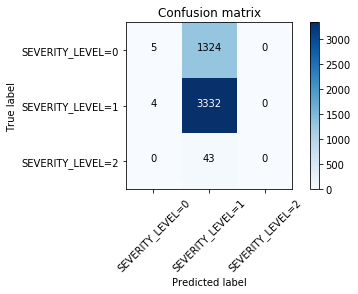

In [74]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_testset, yhat_lr1, labels=[0,1,2])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["SEVERITY_LEVEL=0", "SEVERITY_LEVEL=1", "SEVERITY_LEVEL=2"],normalize= False,  title='Confusion matrix')

In [75]:
print (classification_report(y_testset, yhat_lr1))

              precision    recall  f1-score   support

           0       0.56      0.00      0.01      1329
           1       0.71      1.00      0.83      3336
           2       0.00      0.00      0.00        43

   micro avg       0.71      0.71      0.71      4708
   macro avg       0.42      0.33      0.28      4708
weighted avg       0.66      0.71      0.59      4708



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [76]:
log_loss(y_testset, yhat_prob1)

0.6401573637769501

##### 4. A. 6. Model #1 Statistical Summary

In [77]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [78]:
regression_results(y_testset,yhat_lr1)

explained_variance:  -0.0038
mean_squared_log_error:  0.137
r2:  -0.3432
MAE:  0.2912
MSE:  0.2912
RMSE:  0.5396


In [79]:
# printing the summary table 
print(log_reg1.summary()) 

                          MNLogit Regression Results                          
Dep. Variable:         SEVERITY_LEVEL   No. Observations:                10983
Model:                        MNLogit   Df Residuals:                    10951
Method:                           MLE   Df Model:                           30
Date:                Sun, 27 Sep 2020   Pseudo R-squ.:                0.008515
Time:                        18:16:47   Log-Likelihood:                -6977.1
converged:                      False   LL-Null:                       -7037.0
                                        LLR p-value:                 1.083e-12
SEVERITY_LEVEL=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
x1                   0.0228      0.001     26.660      0.000       0.021       0.025
x2                   0.3142      0.043      7.371      0.000       0.231       0.398
x3                   0.0145 

/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:3967: RuntimeWarning: invalid value encountered in sqrt
  bse = np.sqrt(np.diag(self.cov_params()))
/opt/conda/envs/Python36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/envs/Python36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/envs/Python36/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


##### 4. A. 7. Model #1: Checking statistical assumptions
This initial model I've built has decent accuracy, with a Jaccard score of 0.708 and an F1 score of 0.59. However, I suspect that the model is overfitted due to multicollinearity &mdash; correlations between predictors in the model. Now I will work to identify which variables to keep in the model and which ones to lose, to make it stronger.

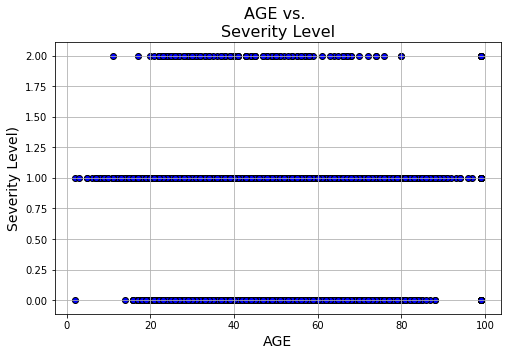

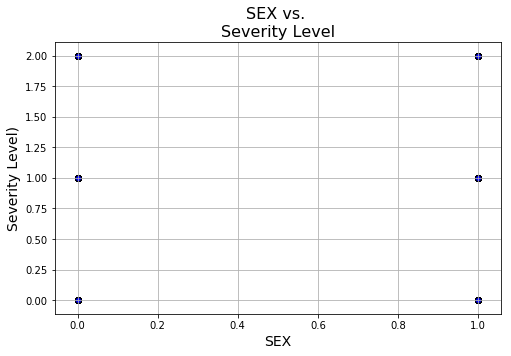

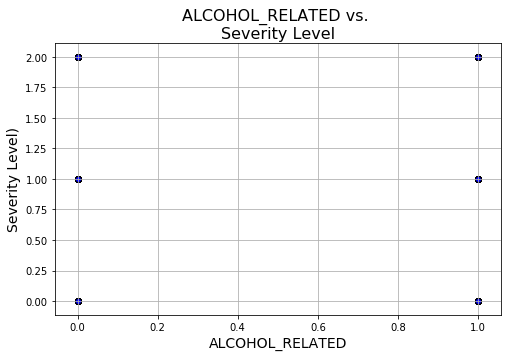

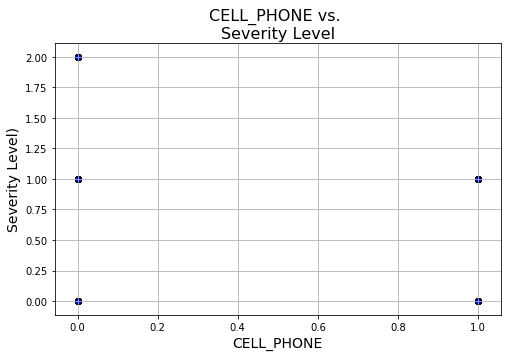

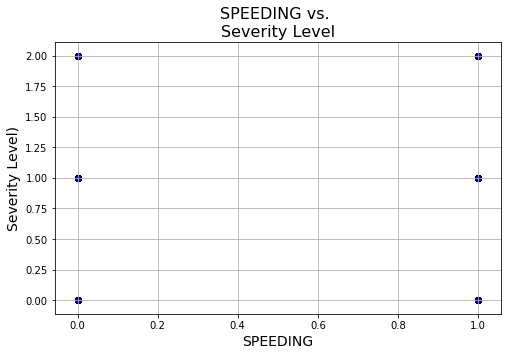

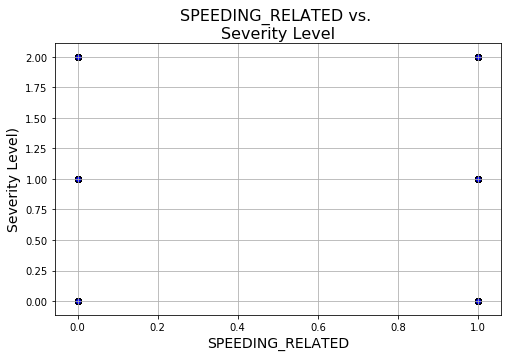

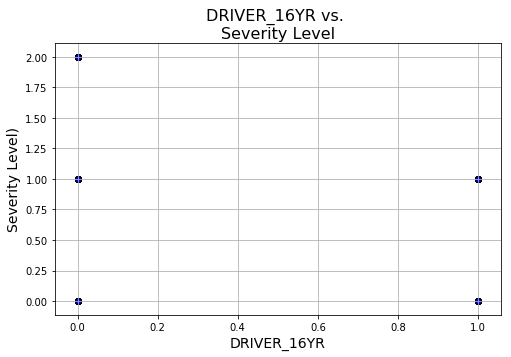

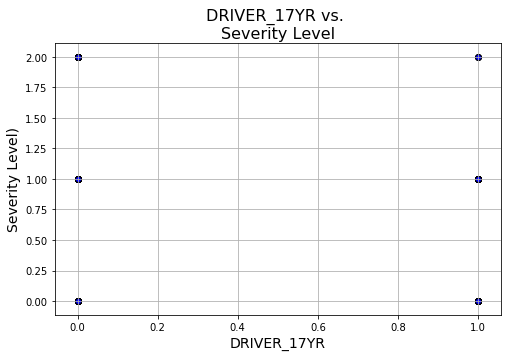

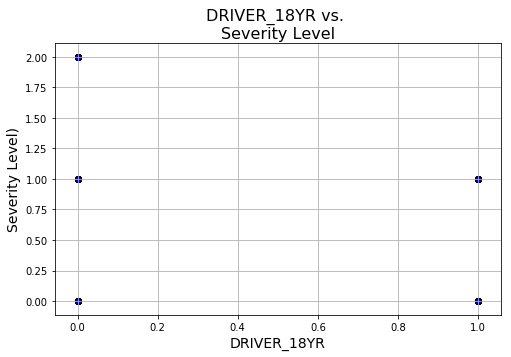

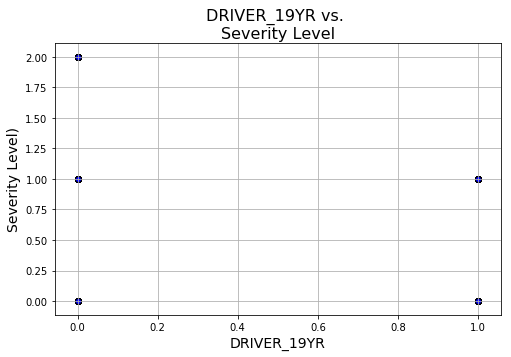

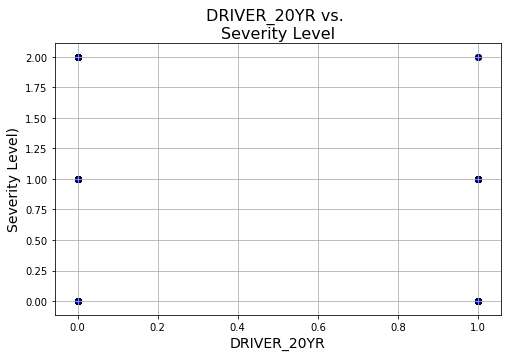

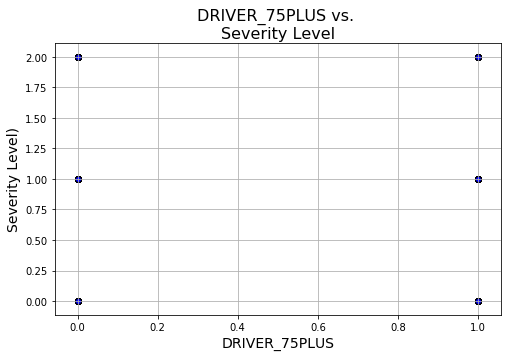

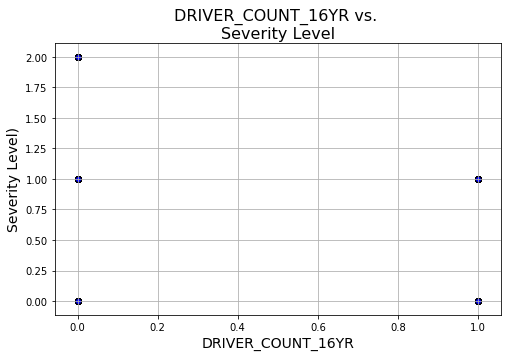

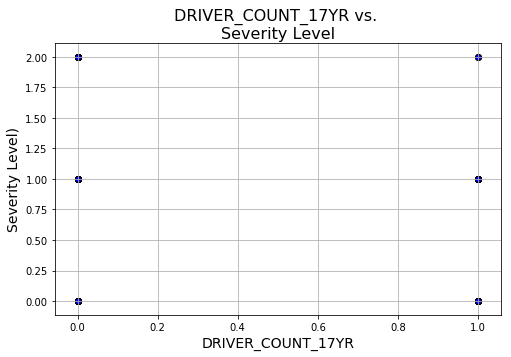

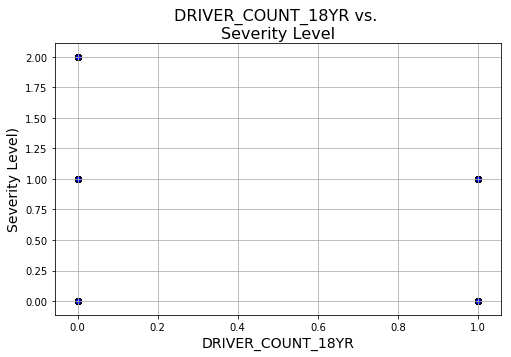

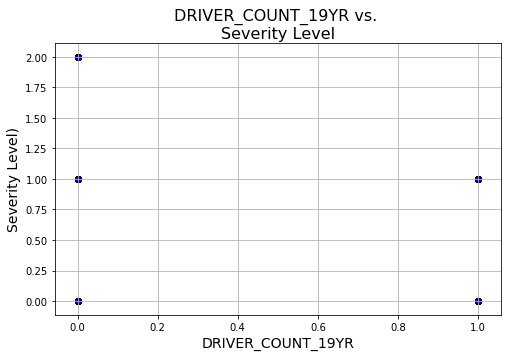

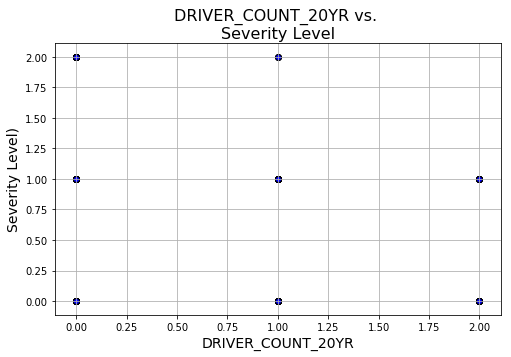

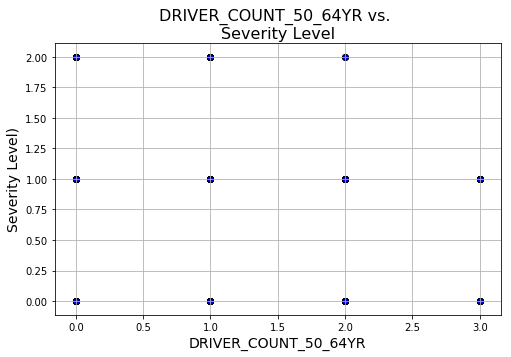

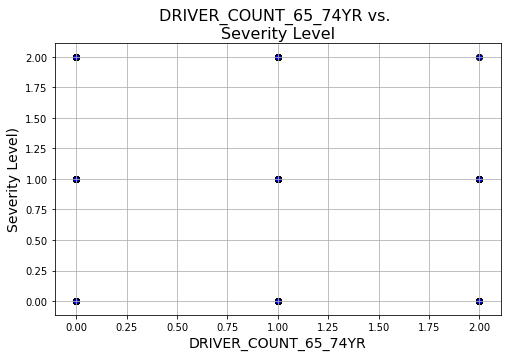

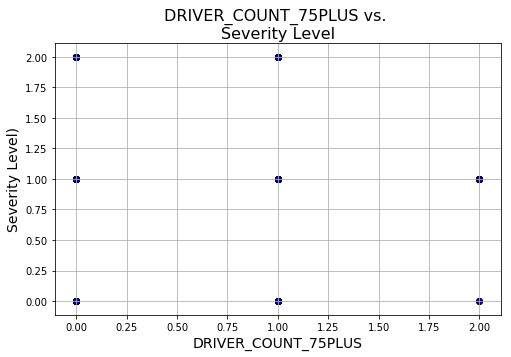

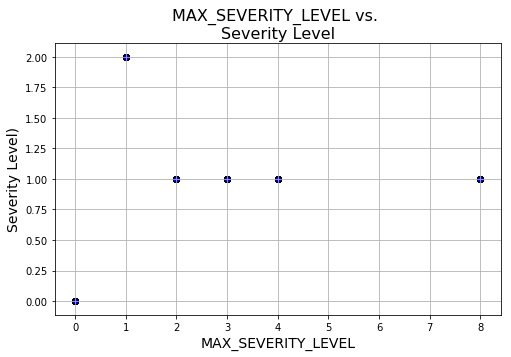

In [80]:
for c in df_r1.columns[:-1]:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nSeverity Level".format(c),fontsize=16)
    plt.scatter(x=df[c],y=df['SEVERITY_LEVEL'],color='blue',edgecolor='k')
    plt.grid(True)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Severity Level)',fontsize=14)
    plt.show()

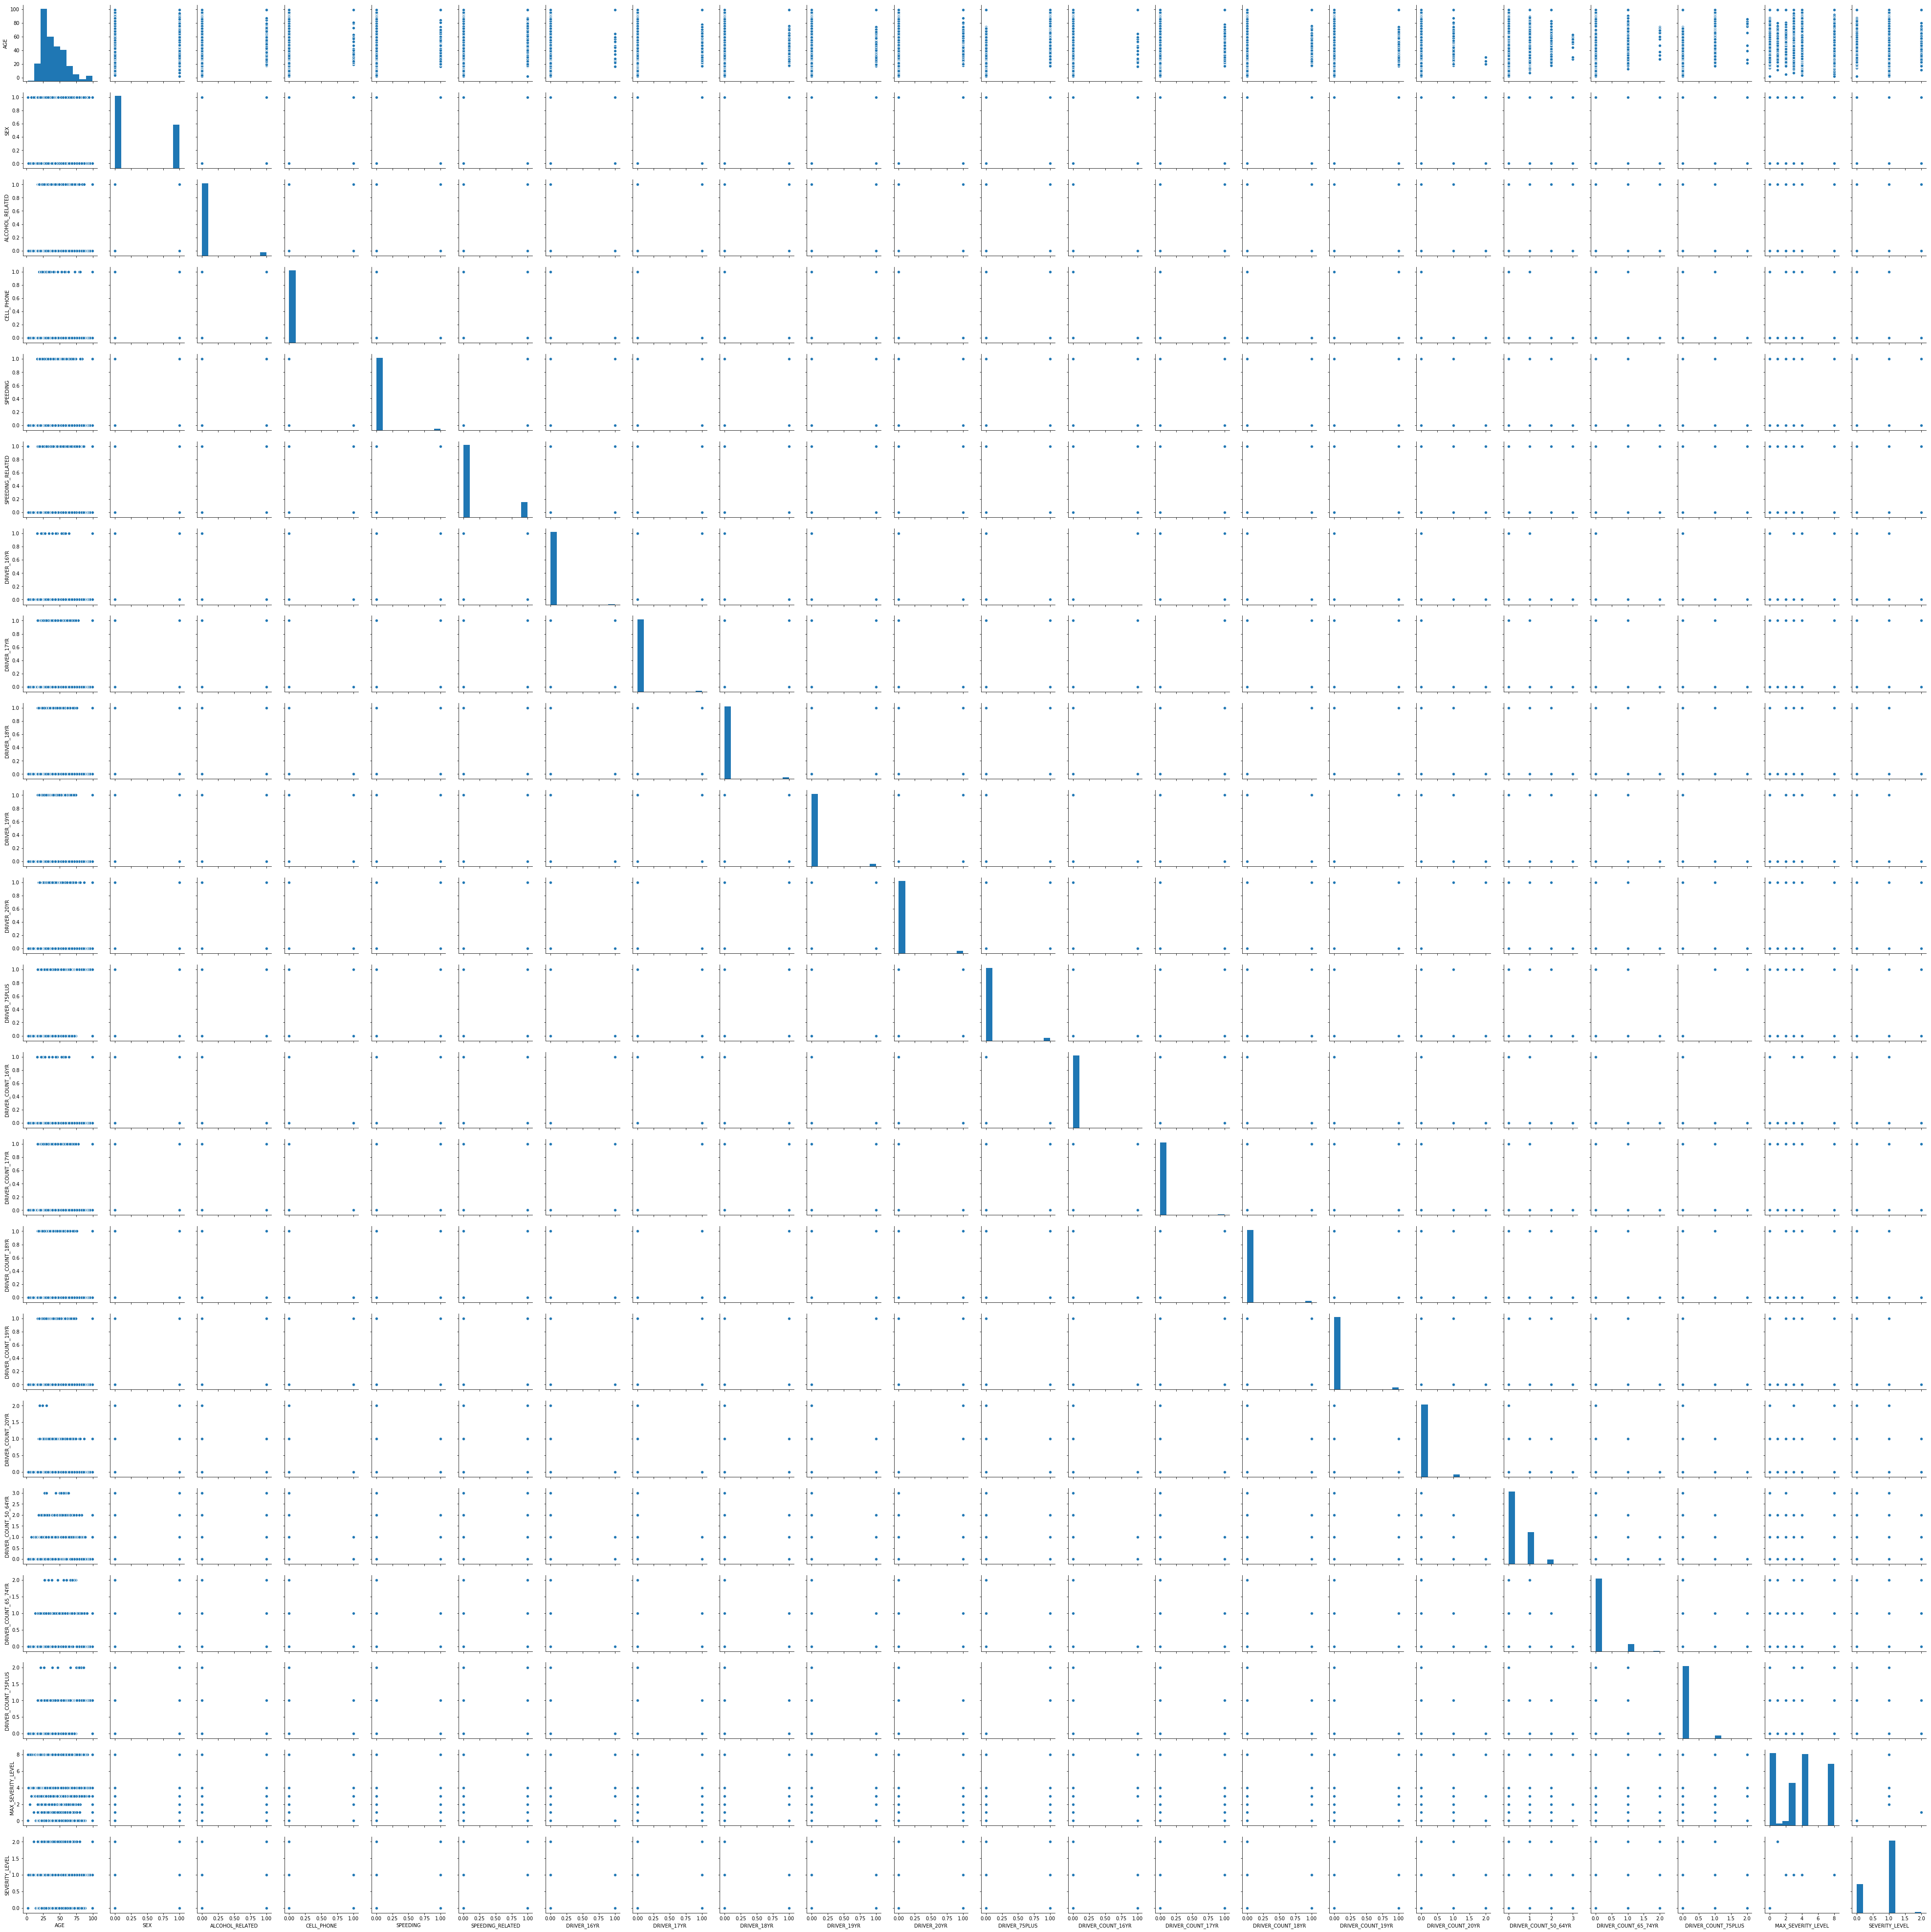

In [81]:
pairplot(df_r1)

In [82]:
corr1 = df_r1[:-1].corr()

In [83]:
corr1

,AGE,SEX,ALCOHOL_RELATED,CELL_PHONE,SPEEDING,SPEEDING_RELATED,DRIVER_16YR,DRIVER_17YR,DRIVER_18YR,DRIVER_19YR,...,DRIVER_COUNT_16YR,DRIVER_COUNT_17YR,DRIVER_COUNT_18YR,DRIVER_COUNT_19YR,DRIVER_COUNT_20YR,DRIVER_COUNT_50_64YR,DRIVER_COUNT_65_74YR,DRIVER_COUNT_75PLUS,MAX_SEVERITY_LEVEL,SEVERITY_LEVEL
AGE,1.000000,-0.067439,-0.010701,-0.007111,-0.010069,-0.078373,-0.033751,-0.068266,-0.088337,-0.111553,...,-0.033751,-0.068266,-0.088337,-0.111553,-0.114581,0.282453,0.245067,0.240844,0.082672,0.090709
SEX,-0.067439,1.000000,-0.041835,0.009615,-0.027554,-0.045278,0.012444,0.002566,0.019403,0.006939,...,0.012444,0.002566,0.019403,0.006939,0.005065,-0.022583,-0.011876,0.015938,0.035290,0.033954
ALCOHOL_RELATED,-0.010701,-0.041835,1.000000,0.016528,0.037997,-0.002711,-0.010268,-0.015626,-0.006330,-0.014407,...,-0.010268,-0.015626,-0.006330,-0.014407,-0.013815,-0.016016,-0.019159,-0.015289,-0.008952,0.021596
CELL_PHONE,-0.007111,0.009615,0.016528,1.000000,-0.007538,-0.013764,-0.002786,-0.006522,-0.008326,0.003234,...,-0.002786,-0.006522,-0.008326,0.003234,-0.010586,0.001669,-0.014189,0.011587,0.004249,0.013965
SPEEDING,-0.010069,-0.027554,0.037997,-0.007538,1.000000,0.292685,0.003330,0.018819,-0.009504,0.013424,...,0.003330,0.018819,-0.009504,0.013424,0.023707,-0.020950,-0.008907,-0.004203,-0.012730,0.025435
SPEEDING_RELATED,-0.078373,-0.045278,-0.002711,-0.013764,0.292685,1.000000,0.005054,0.063235,0.018499,0.034107,...,0.005054,0.063235,0.018499,0.034107,0.022342,0.022960,-0.008260,-0.045329,-0.094286,-0.135585
DRIVER_16YR,-0.033751,0.012444,-0.010268,-0.002786,0.003330,0.005054,1.000000,0.017099,-0.007256,-0.008697,...,1.000000,0.017099,-0.007256,-0.008697,-0.009225,-0.010196,-0.015568,-0.009669,0.011615,0.006815
DRIVER_17YR,-0.068266,0.002566,-0.015626,-0.006522,0.018819,0.063235,0.017099,1.000000,0.002439,-0.013815,...,0.017099,1.000000,0.002439,-0.013815,-0.021595,-0.028909,-0.001861,-0.017019,-0.023302,-0.014918
DRIVER_18YR,-0.088337,0.019403,-0.006330,-0.008326,-0.009504,0.018499,-0.007256,0.002439,1.000000,-0.013073,...,-0.007256,0.002439,1.000000,-0.013073,-0.004290,-0.004976,-0.010589,-0.024461,-0.023583,-0.018533
DRIVER_19YR,-0.111553,0.006939,-0.014407,0.003234,0.013424,0.034107,-0.008697,-0.013815,-0.013073,1.000000,...,-0.008697,-0.013815,-0.013073,1.000000,-0.025203,-0.027989,-0.019453,-0.034635,-0.014845,-0.022213


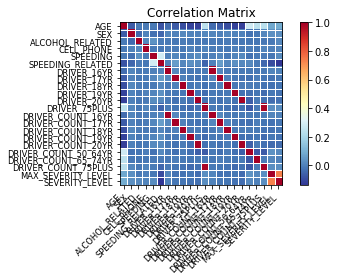

In [84]:
fig1=plot_corr(corr1,xnames=corr1.columns)

#### 4. B. Model #2

Already, I have made some changes to the first version of the model in the code above. I initially split the SEX variable into separate dummy variables because one of the labs recommended it. Ultimately I converted the original SEX variable into a binary variable by dropping both blank and "Unknown" rows. I also dropped the 'DRINKING_DRIVER' and 'UNDERAGE_DRNK_DRV' columns, because they were highly correlated with 'ALCOHOL_RELATED.' In Model 2, I remove more columns from the dataframe before rebuilding the model. Specifically, I'm removing the "Driver_age_counts" variables, as they're correlated with the "driver_age" variables, and I'm removing "Speeding_related" as redundant with "SPEEDING". Finally, I'm removing MAX_SEVERITY_LEVEL because SEVERITY_LEVEL was derived from it, so I shouldn't need both.

##### 4. B. 1. Create dataframe

In [85]:
df_r2 = df[['AGE','SEX','ALCOHOL_RELATED','CELL_PHONE','SPEEDING','DRIVER_16YR','DRIVER_17YR','DRIVER_18YR','DRIVER_19YR','DRIVER_20YR','DRIVER_75PLUS','SEVERITY_LEVEL']]

In [86]:
df_r2.shape

(15691, 12)

In [87]:
df_r2.head()

,AGE,SEX,ALCOHOL_RELATED,CELL_PHONE,SPEEDING,DRIVER_16YR,DRIVER_17YR,DRIVER_18YR,DRIVER_19YR,DRIVER_20YR,DRIVER_75PLUS,SEVERITY_LEVEL
CRN,,,,,,,,,,,,
2018000618,39,0.0,0,0,0,0,0,0,0,0,0,1
2018001306,55,0.0,0,0,0,0,0,0,0,0,0,1
2018001756,17,0.0,0,0,0,0,1,0,0,0,0,1
2018002147,18,0.0,0,0,0,0,0,1,0,0,0,0
2018002537,30,0.0,0,0,0,0,0,0,0,0,0,1


##### 4. B. 2. Define X & y, and split into training & testing sets

In [88]:
X2 = df_r2[['AGE','SEX','ALCOHOL_RELATED','CELL_PHONE','SPEEDING','DRIVER_16YR','DRIVER_17YR','DRIVER_18YR','DRIVER_19YR','DRIVER_20YR','DRIVER_75PLUS']].values

In [89]:
X2[0:5]

array([[39.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [17.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [18.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [90]:
y2 = df_r2['SEVERITY_LEVEL']
y2[0:5]

CRN
2018000618    1
2018001306    1
2018001756    1
2018002147    0
2018002537    1
Name: SEVERITY_LEVEL, dtype: int64

In [91]:
X2_trainset, X2_testset, y2_trainset, y2_testset = train_test_split(X2, y, test_size=0.3, random_state=3)

In [92]:
print("Size of X1_trainset: ",X2_trainset.shape)
print("Size of y_trainset: ",y2_trainset.shape)
print("Size of X1_testset: ",X2_testset.shape)
print("Size of y_testset: ",y2_testset.shape)

Size of X1_trainset:  (10983, 11)
Size of y_trainset:  (10983,)
Size of X1_testset:  (4708, 11)
Size of y_testset:  (4708,)


##### 4. B. 3. Build Model using SKLearn methods

In [93]:
LR2 = LogisticRegression(C=0.01, solver='liblinear', multi_class='auto').fit(X2_trainset,y2_trainset)
LR2

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [94]:
yhat_lr2 = LR2.predict(X2_testset)
yhat_lr2

array([1, 1, 1, ..., 1, 1, 1])

In [95]:
yhat_prob2 = LR2.predict_proba(X2_testset)
yhat_prob2

array([[3.19e-01, 6.67e-01, 1.40e-02],
       [1.98e-01, 8.02e-01, 3.03e-04],
       [2.81e-01, 7.08e-01, 1.11e-02],
       ...,
       [1.73e-01, 8.27e-01, 9.59e-05],
       [3.01e-01, 6.93e-01, 6.71e-03],
       [3.03e-01, 6.66e-01, 3.11e-02]])

In [96]:
print('Coefficients: ', LR2.coef_)

Coefficients:  [[-0.01 -0.2  -0.02 -0.03 -0.08 -0.02  0.05  0.03 -0.    0.1  -0.01]
 [ 0.01  0.21 -0.08  0.03 -0.02  0.02 -0.04 -0.02  0.01 -0.09  0.01]
 [-0.11 -0.33  0.15 -0.01  0.12 -0.01 -0.04 -0.08 -0.1  -0.1   0.02]]


##### 4. B. 4. Build model with StatsModels

In [97]:
# building the model and fitting the data 
log_reg2 = sm.MNLogit(y2_trainset, X2_trainset).fit() 

         Current function value: 0.645435
         Iterations: 35


/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [98]:
yhat_lr2sm = log_reg2.predict(X2_testset) 
#prediction = list(map(round, yhat_lr2sm)) 

In [99]:
# comparing original and predicted values of y 
print('Acutal values', y2_testset[0:5]) 
print('Predictions :', yhat_lr2sm[0:5]) 

Acutal values CRN
2018088445    1
2018136848    0
2019084629    1
2018054169    1
2018123528    0
Name: SEVERITY_LEVEL, dtype: int64
Predictions : [[3.41e-01 6.41e-01 1.82e-02]
 [1.73e-01 8.27e-01 1.34e-04]
 [2.84e-01 7.11e-01 4.52e-03]
 [2.00e-01 7.99e-01 4.47e-04]
 [2.48e-01 7.51e-01 1.62e-03]]


In [100]:
formula_str2 = df_r2.columns[-1]+' ~ '+'+'.join(df_r2.columns[:-1])

In [101]:
formula_str2

'SEVERITY_LEVEL ~ AGE+SEX+ALCOHOL_RELATED+CELL_PHONE+SPEEDING+DRIVER_16YR+DRIVER_17YR+DRIVER_18YR+DRIVER_19YR+DRIVER_20YR+DRIVER_75PLUS'

##### 4. B. 5. Model #2 Predictive Accuracy

In [102]:
jaccard_similarity_score(y2_testset, yhat_lr2)

0.7085811384876806

In [103]:
print(confusion_matrix(y2_testset, yhat_lr2, labels=[0,1,2]))

[[   0 1329    0]
 [   0 3336    0]
 [   0   43    0]]


Confusion matrix, without normalization
[[   0 1329    0]
 [   0 3336    0]
 [   0   43    0]]


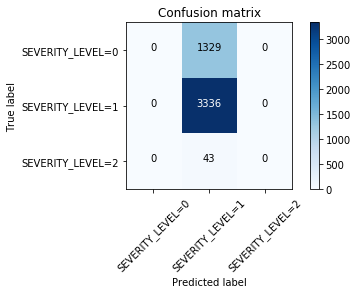

In [104]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y2_testset, yhat_lr2, labels=[0,1,2])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["SEVERITY_LEVEL=0", "SEVERITY_LEVEL=1", "SEVERITY_LEVEL=2"],normalize= False,  title='Confusion matrix')

In [105]:
print (classification_report(y2_testset, yhat_lr2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1329
           1       0.71      1.00      0.83      3336
           2       0.00      0.00      0.00        43

   micro avg       0.71      0.71      0.71      4708
   macro avg       0.24      0.33      0.28      4708
weighted avg       0.50      0.71      0.59      4708



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [106]:
log_loss(y2_testset, yhat_prob2)

0.6476053070669625

##### 4. B. 6. Model #2 Statistical Summary

In [107]:
regression_results(y2_testset,yhat_lr2)

explained_variance:  0.0
mean_squared_log_error:  0.1371
r2:  -0.3441
MAE:  0.2914
MSE:  0.2914
RMSE:  0.5398


In [108]:
# printing the summary table 
print(log_reg2.summary()) 

                          MNLogit Regression Results                          
Dep. Variable:         SEVERITY_LEVEL   No. Observations:                10983
Model:                        MNLogit   Df Residuals:                    10961
Method:                           MLE   Df Model:                           20
Date:                Sun, 27 Sep 2020   Pseudo R-squ.:               -0.007365
Time:                        18:22:14   Log-Likelihood:                -7088.8
converged:                      False   LL-Null:                       -7037.0
                                        LLR p-value:                     1.000
SEVERITY_LEVEL=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
x1                   0.0191      0.001     30.154      0.000       0.018       0.020
x2                   0.3079      0.042      7.304      0.000       0.225       0.390
x3                   0.0078 

##### 4. B. 7. Model #2: Checking statistical assumptions
This second model I've built has the same accuracy as the first one, with a Jaccard score of 0.708 and an F1 score of 0.59. I will keep testing to identify which variables to keep in the model and which ones to lose, to make it stronger.

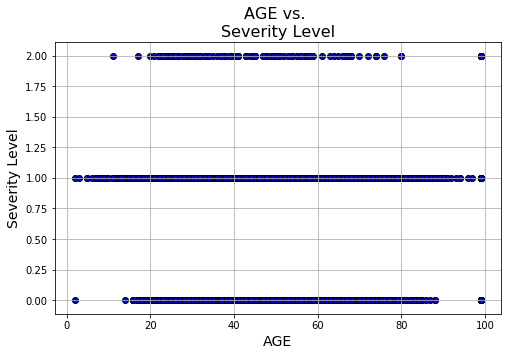

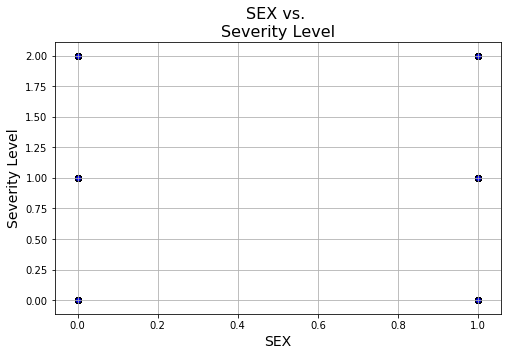

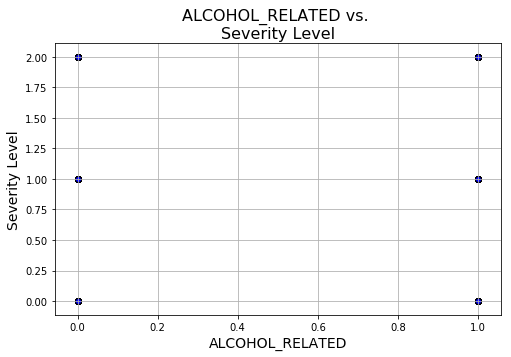

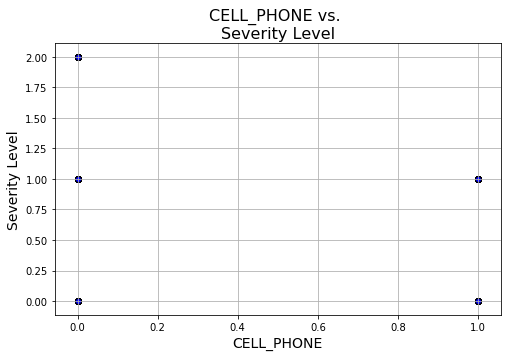

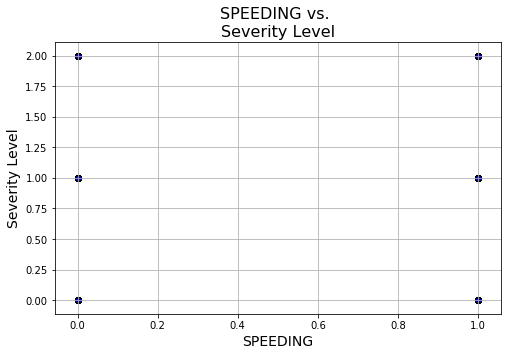

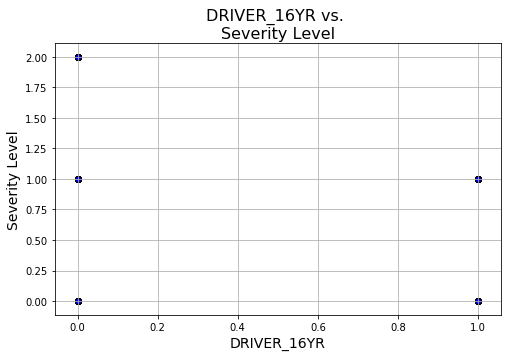

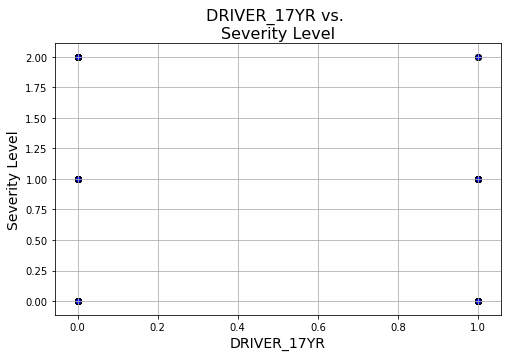

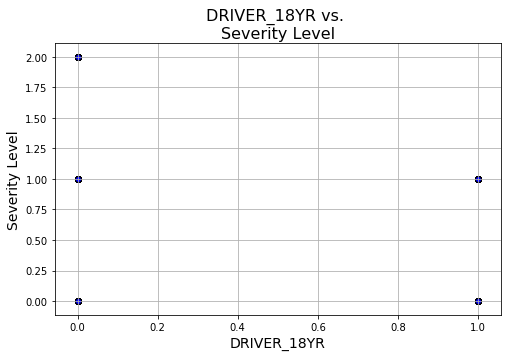

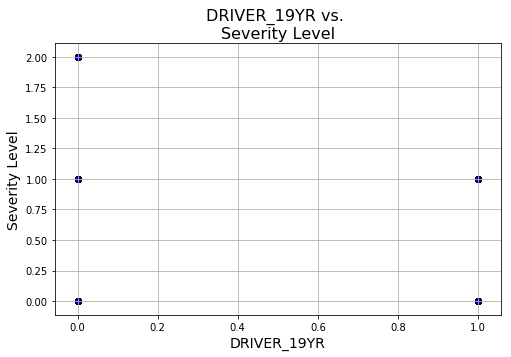

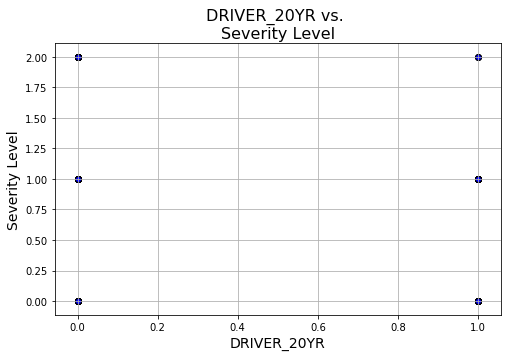

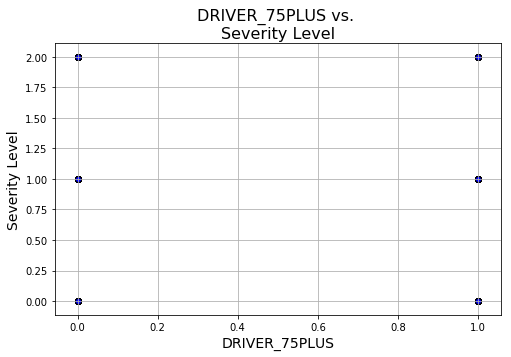

In [109]:
for c in df_r2.columns[:-1]:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nSeverity Level".format(c),fontsize=16)
    plt.scatter(x=df[c],y=df['SEVERITY_LEVEL'],color='blue',edgecolor='k')
    plt.grid(True)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Severity Level',fontsize=14)
    plt.show()

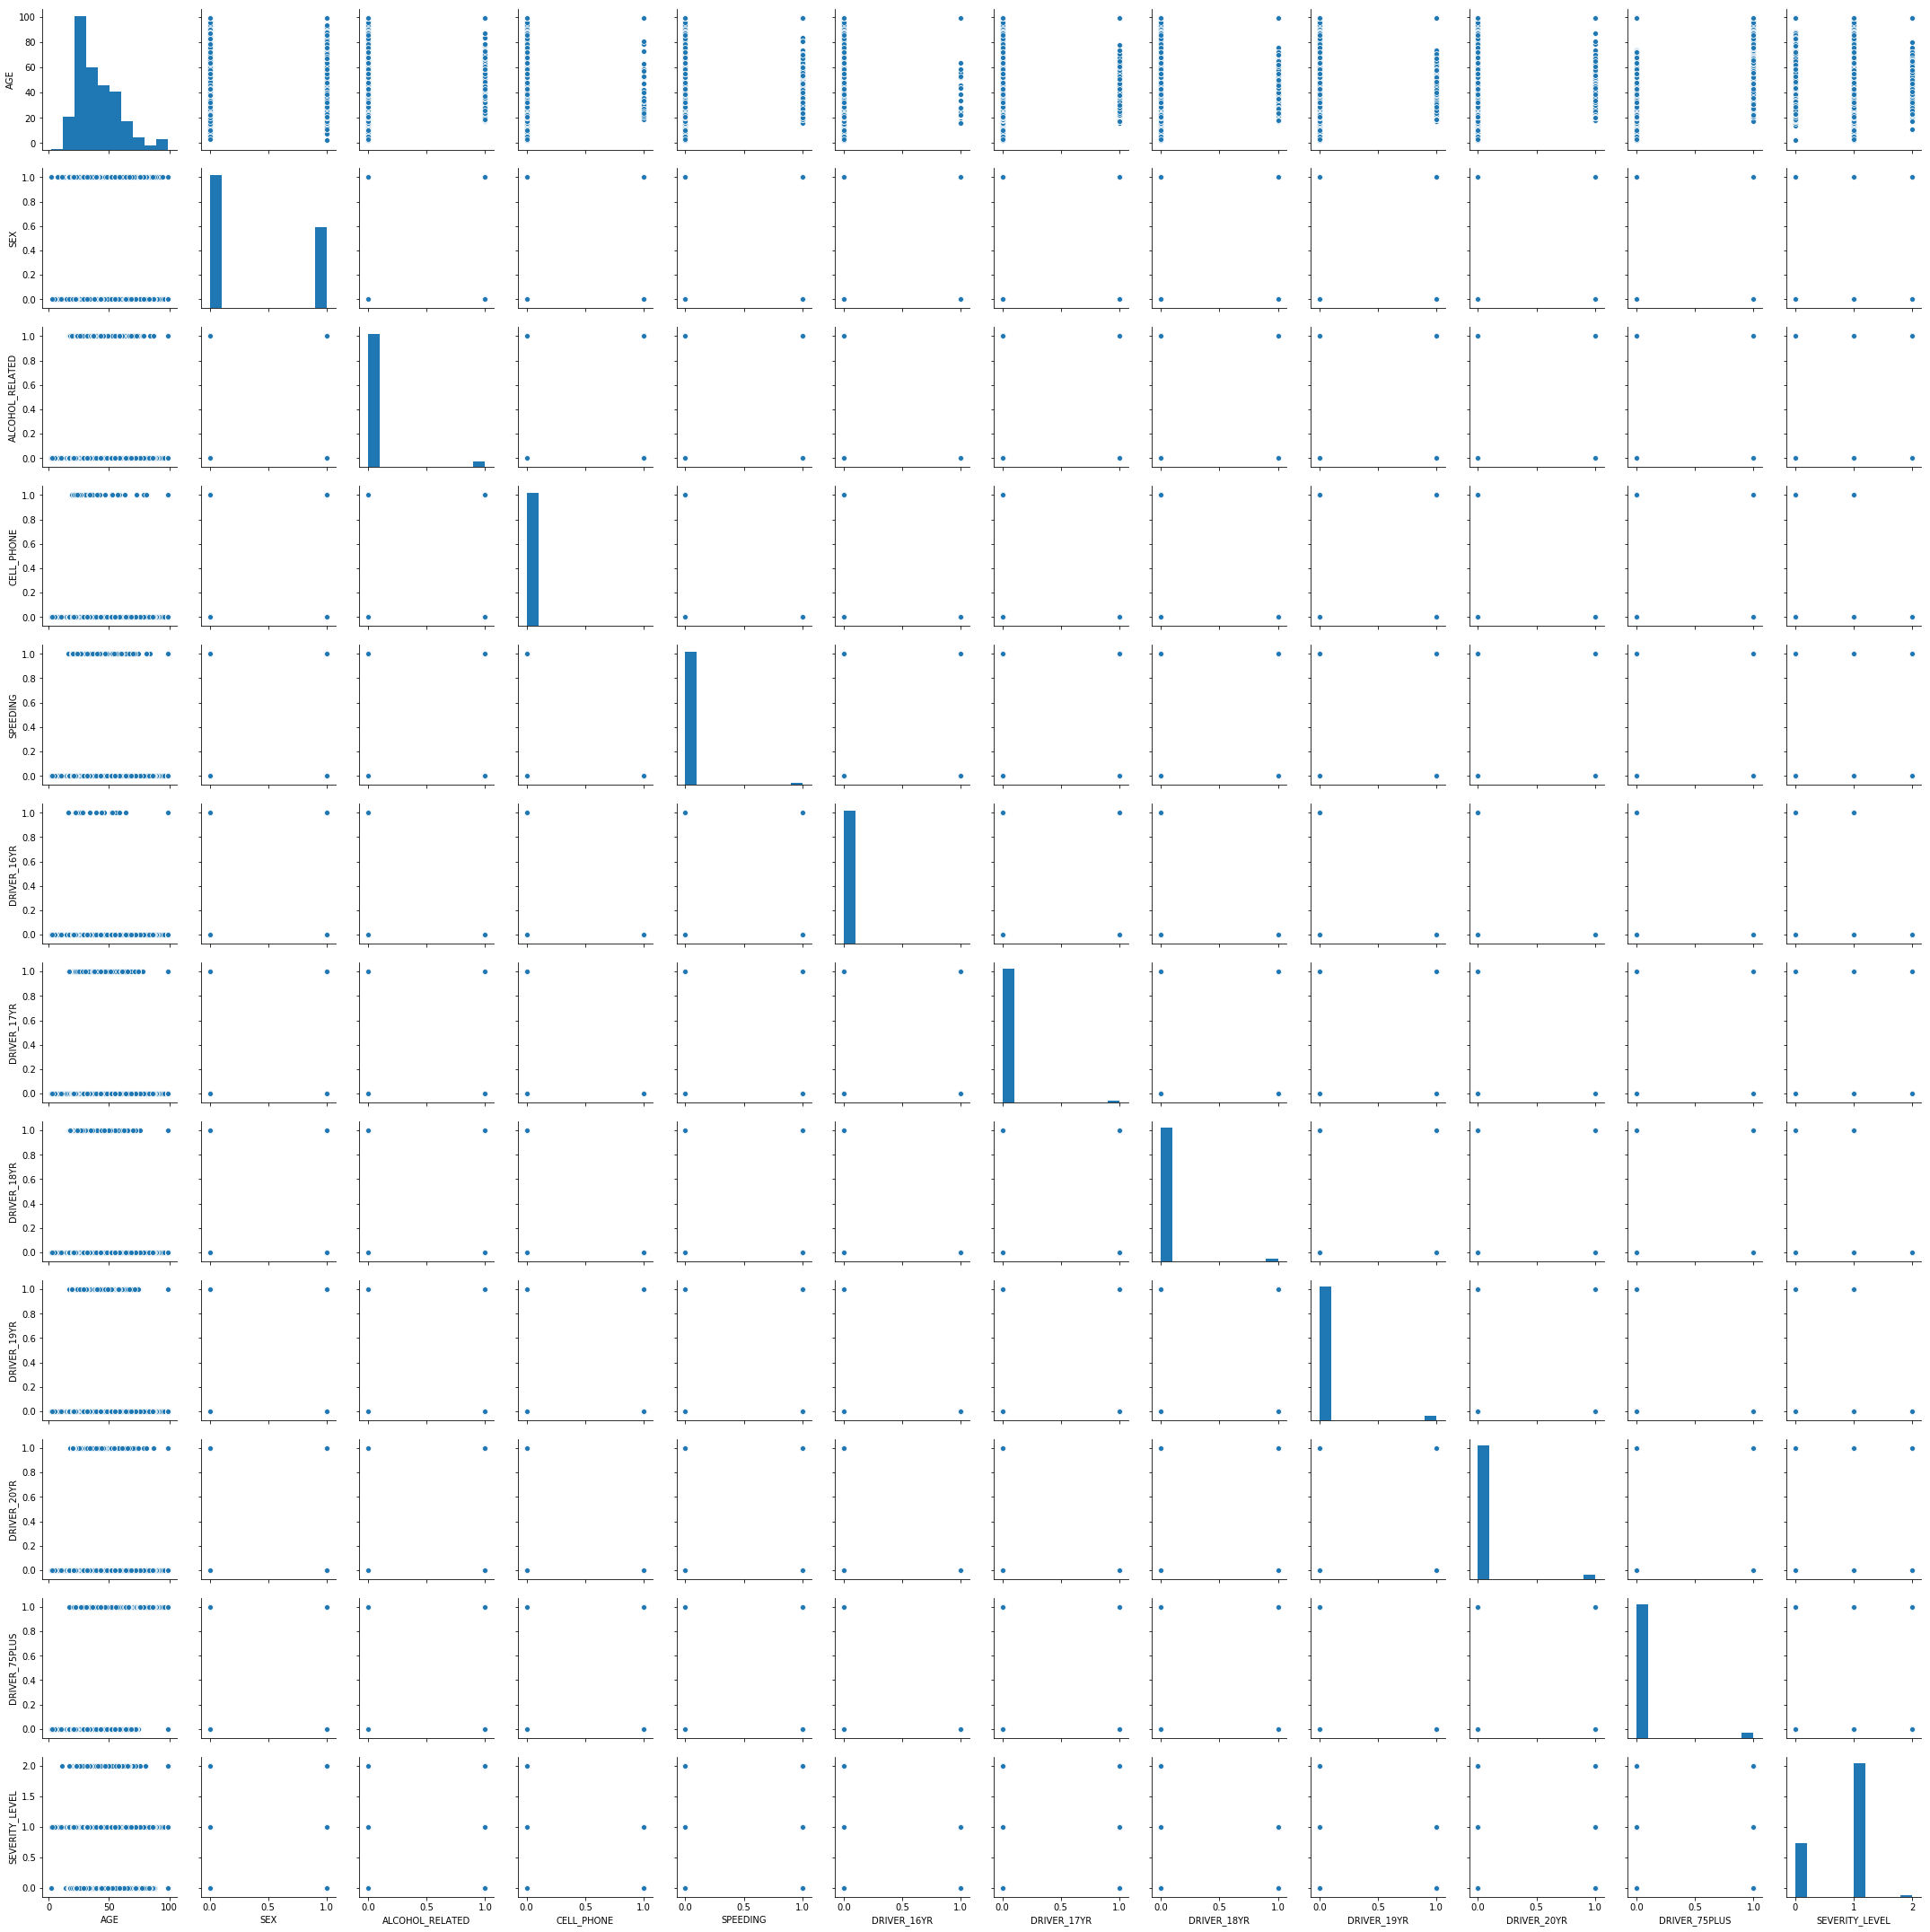

In [110]:
pairplot(df_r2)

In [111]:
corr2 = df_r2[:-1].corr()

In [112]:
corr2

,AGE,SEX,ALCOHOL_RELATED,CELL_PHONE,SPEEDING,DRIVER_16YR,DRIVER_17YR,DRIVER_18YR,DRIVER_19YR,DRIVER_20YR,DRIVER_75PLUS,SEVERITY_LEVEL
AGE,1.000000,-0.067439,-0.010701,-0.007111,-0.010069,-0.033751,-0.068266,-0.088337,-0.111553,-0.113534,0.241815,0.090709
SEX,-0.067439,1.000000,-0.041835,0.009615,-0.027554,0.012444,0.002566,0.019403,0.006939,0.004746,0.016213,0.033954
ALCOHOL_RELATED,-0.010701,-0.041835,1.000000,0.016528,0.037997,-0.010268,-0.015626,-0.006330,-0.014407,-0.013328,-0.014756,0.021596
CELL_PHONE,-0.007111,0.009615,0.016528,1.000000,-0.007538,-0.002786,-0.006522,-0.008326,0.003234,-0.010716,0.012398,0.013965
SPEEDING,-0.010069,-0.027554,0.037997,-0.007538,1.000000,0.003330,0.018819,-0.009504,0.013424,0.025266,-0.003626,0.025435
DRIVER_16YR,-0.033751,0.012444,-0.010268,-0.002786,0.003330,1.000000,0.017099,-0.007256,-0.008697,-0.009338,-0.009800,0.006815
DRIVER_17YR,-0.068266,0.002566,-0.015626,-0.006522,0.018819,0.017099,1.000000,0.002439,-0.013815,-0.021860,-0.017087,-0.014918
DRIVER_18YR,-0.088337,0.019403,-0.006330,-0.008326,-0.009504,-0.007256,0.002439,1.000000,-0.013073,-0.003736,-0.024664,-0.018533
DRIVER_19YR,-0.111553,0.006939,-0.014407,0.003234,0.013424,-0.008697,-0.013815,-0.013073,1.000000,-0.025308,-0.035103,-0.022213
DRIVER_20YR,-0.113534,0.004746,-0.013328,-0.010716,0.025266,-0.009338,-0.021860,-0.003736,-0.025308,1.000000,-0.026766,-0.028098


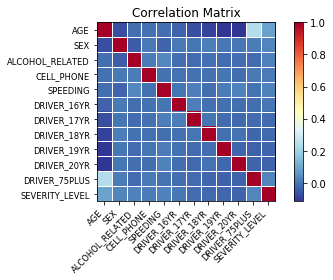

In [113]:
fig2=plot_corr(corr2,xnames=corr2.columns)

#### 4. C. Model #3

In this model, I removed three more variables: 'ALCOHOL_RELATED,' 'SPEEDING,' and 'CELL_PHONE' because they are not directly related to the business question, even though an insurance company might use those flags in their models.

##### 4. C. 1. Create dataframe

In [114]:
df_r3 = df[['AGE','SEX','DRIVER_16YR','DRIVER_17YR','DRIVER_18YR','DRIVER_19YR','DRIVER_20YR','DRIVER_75PLUS','SEVERITY_LEVEL']]

In [115]:
df_r3.shape

(15691, 9)

In [116]:
df_r3.head()

,AGE,SEX,DRIVER_16YR,DRIVER_17YR,DRIVER_18YR,DRIVER_19YR,DRIVER_20YR,DRIVER_75PLUS,SEVERITY_LEVEL
CRN,,,,,,,,,
2018000618,39,0.0,0,0,0,0,0,0,1
2018001306,55,0.0,0,0,0,0,0,0,1
2018001756,17,0.0,0,1,0,0,0,0,1
2018002147,18,0.0,0,0,1,0,0,0,0
2018002537,30,0.0,0,0,0,0,0,0,1


##### 4. C. 2. Define X & y, and split into training & testing sets

In [117]:
X3 = df_r3[['AGE','SEX','DRIVER_16YR','DRIVER_17YR','DRIVER_18YR','DRIVER_19YR','DRIVER_20YR','DRIVER_75PLUS']].values

In [118]:
X3[0:5]

array([[39.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [17.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [18.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [119]:
y3 = df_r3['SEVERITY_LEVEL']
y2[0:5]

CRN
2018000618    1
2018001306    1
2018001756    1
2018002147    0
2018002537    1
Name: SEVERITY_LEVEL, dtype: int64

In [120]:
X3_trainset, X3_testset, y3_trainset, y3_testset = train_test_split(X3, y3, test_size=0.3, random_state=3)

In [121]:
print("Size of X1_trainset: ",X3_trainset.shape)
print("Size of y_trainset: ",y3_trainset.shape)
print("Size of X1_testset: ",X3_testset.shape)
print("Size of y_testset: ",y3_testset.shape)

Size of X1_trainset:  (10983, 8)
Size of y_trainset:  (10983,)
Size of X1_testset:  (4708, 8)
Size of y_testset:  (4708,)


##### 4. C. 3. Build Model #3 using SKLearn methods

In [122]:
LR3 = LogisticRegression(C=0.01, solver='liblinear', multi_class='auto').fit(X3_trainset,y3_trainset)
LR3

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [123]:
yhat_lr3 = LR3.predict(X3_testset)
yhat_lr3

array([1, 1, 1, ..., 1, 1, 1])

In [124]:
yhat_prob3 = LR3.predict_proba(X3_testset)
yhat_prob3

array([[3.19e-01, 6.67e-01, 1.41e-02],
       [1.97e-01, 8.02e-01, 3.09e-04],
       [2.81e-01, 7.08e-01, 1.13e-02],
       ...,
       [1.72e-01, 8.28e-01, 9.81e-05],
       [3.01e-01, 6.93e-01, 6.80e-03],
       [3.03e-01, 6.66e-01, 3.13e-02]])

In [125]:
print('Coefficients: ', LR3.coef_)

Coefficients:  [[-0.01 -0.2  -0.02  0.05  0.03 -0.    0.09 -0.01]
 [ 0.01  0.21  0.02 -0.04 -0.02  0.01 -0.09  0.01]
 [-0.11 -0.33 -0.01 -0.04 -0.08 -0.1  -0.1   0.02]]


##### 4. C. 4. Build model #3 with StatsModels

In [126]:
# building the model and fitting the data 
log_reg3 = sm.MNLogit(y3_trainset, X3_trainset).fit() 

         Current function value: 0.647961
         Iterations: 35


/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [127]:
yhat_lr3sm = log_reg3.predict(X3_testset) 
#prediction = list(map(round, yhat_lr2sm)) 

In [128]:
# comparing original and predicted values of y 
print('Acutal values', y3_testset[0:5]) 
print('Predictions :', yhat_lr3sm[0:5]) 

Acutal values CRN
2018088445    1
2018136848    0
2019084629    1
2018054169    1
2018123528    0
Name: SEVERITY_LEVEL, dtype: int64
Predictions : [[3.39e-01 6.39e-01 2.23e-02]
 [1.71e-01 8.28e-01 2.01e-04]
 [2.83e-01 7.12e-01 5.47e-03]
 [1.99e-01 8.01e-01 7.40e-04]
 [2.46e-01 7.51e-01 2.09e-03]]


In [129]:
formula_str3 = df_r3.columns[-1]+' ~ '+'+'.join(df_r3.columns[:-1])

In [130]:
formula_str3

'SEVERITY_LEVEL ~ AGE+SEX+DRIVER_16YR+DRIVER_17YR+DRIVER_18YR+DRIVER_19YR+DRIVER_20YR+DRIVER_75PLUS'

##### 4. C. 5. Model #3 Predictive Accuracy

In [131]:
jaccard_similarity_score(y3_testset, yhat_lr3)

0.7085811384876806

In [132]:
print(confusion_matrix(y3_testset, yhat_lr3, labels=[0,1,2]))

[[   0 1329    0]
 [   0 3336    0]
 [   0   43    0]]


Confusion matrix, without normalization
[[   0 1329    0]
 [   0 3336    0]
 [   0   43    0]]


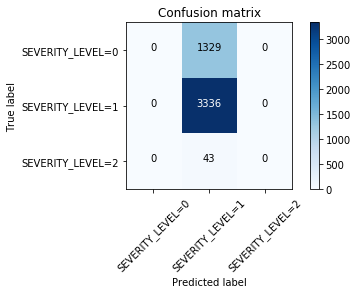

In [133]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y3_testset, yhat_lr3, labels=[0,1,2])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["SEVERITY_LEVEL=0", "SEVERITY_LEVEL=1", "SEVERITY_LEVEL=2"],normalize= False,  title='Confusion matrix')

In [134]:
print (classification_report(y3_testset, yhat_lr3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1329
           1       0.71      1.00      0.83      3336
           2       0.00      0.00      0.00        43

   micro avg       0.71      0.71      0.71      4708
   macro avg       0.24      0.33      0.28      4708
weighted avg       0.50      0.71      0.59      4708



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [135]:
log_loss(y3_testset, yhat_prob3)

0.6480436298207022

##### 4. C. 6. Model #3 Statistical Summary

In [136]:
regression_results(y3_testset,yhat_lr3)

explained_variance:  0.0
mean_squared_log_error:  0.1371
r2:  -0.3441
MAE:  0.2914
MSE:  0.2914
RMSE:  0.5398


In [137]:
# printing the summary table 
print(log_reg3.summary()) 

                          MNLogit Regression Results                          
Dep. Variable:         SEVERITY_LEVEL   No. Observations:                10983
Model:                        MNLogit   Df Residuals:                    10967
Method:                           MLE   Df Model:                           14
Date:                Sun, 27 Sep 2020   Pseudo R-squ.:                -0.01131
Time:                        18:24:25   Log-Likelihood:                -7116.6
converged:                      False   LL-Null:                       -7037.0
                                        LLR p-value:                     1.000
SEVERITY_LEVEL=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
x1                   0.0192      0.001     30.830      0.000       0.018       0.020
x2                   0.3093      0.042      7.343      0.000       0.227       0.392
x3                   0.5349 

##### 4. C. 7. Model #3: Checking statistical assumptions
This third model I've built has the same accuracy as the first one, with a Jaccard score of 0.708 and an F1 score of 0.59. I will keep testing to identify which variables to keep in the model and which ones to lose, to make it stronger.

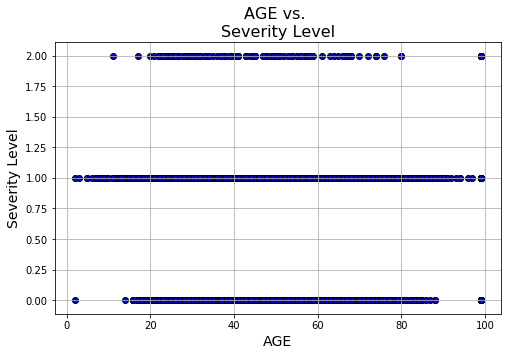

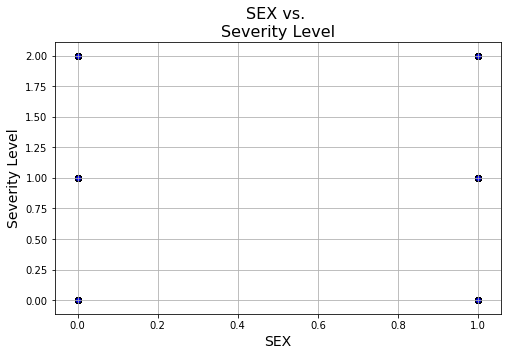

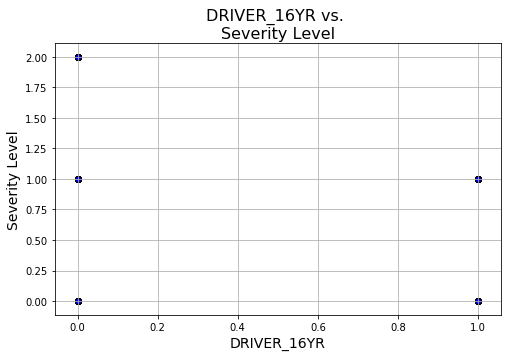

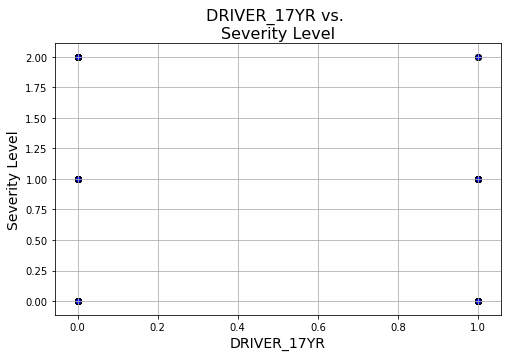

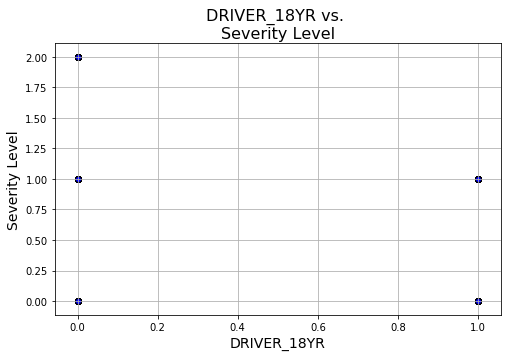

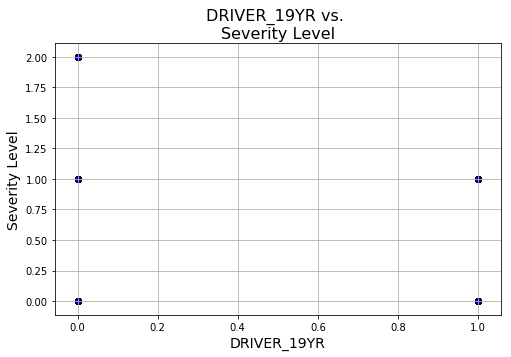

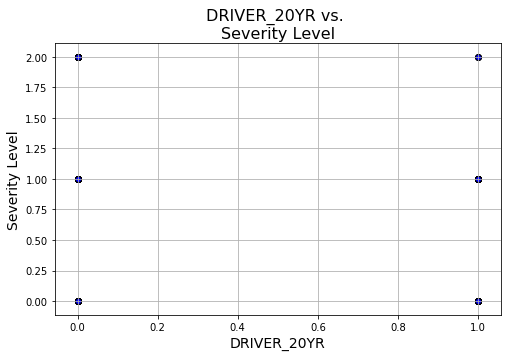

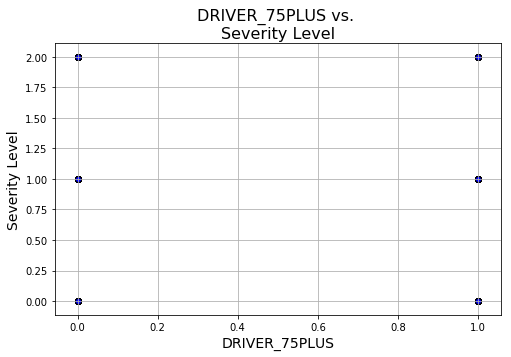

In [138]:
for c in df_r3.columns[:-1]:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nSeverity Level".format(c),fontsize=16)
    plt.scatter(x=df[c],y=df['SEVERITY_LEVEL'],color='blue',edgecolor='k')
    plt.grid(True)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Severity Level',fontsize=14)
    plt.show()

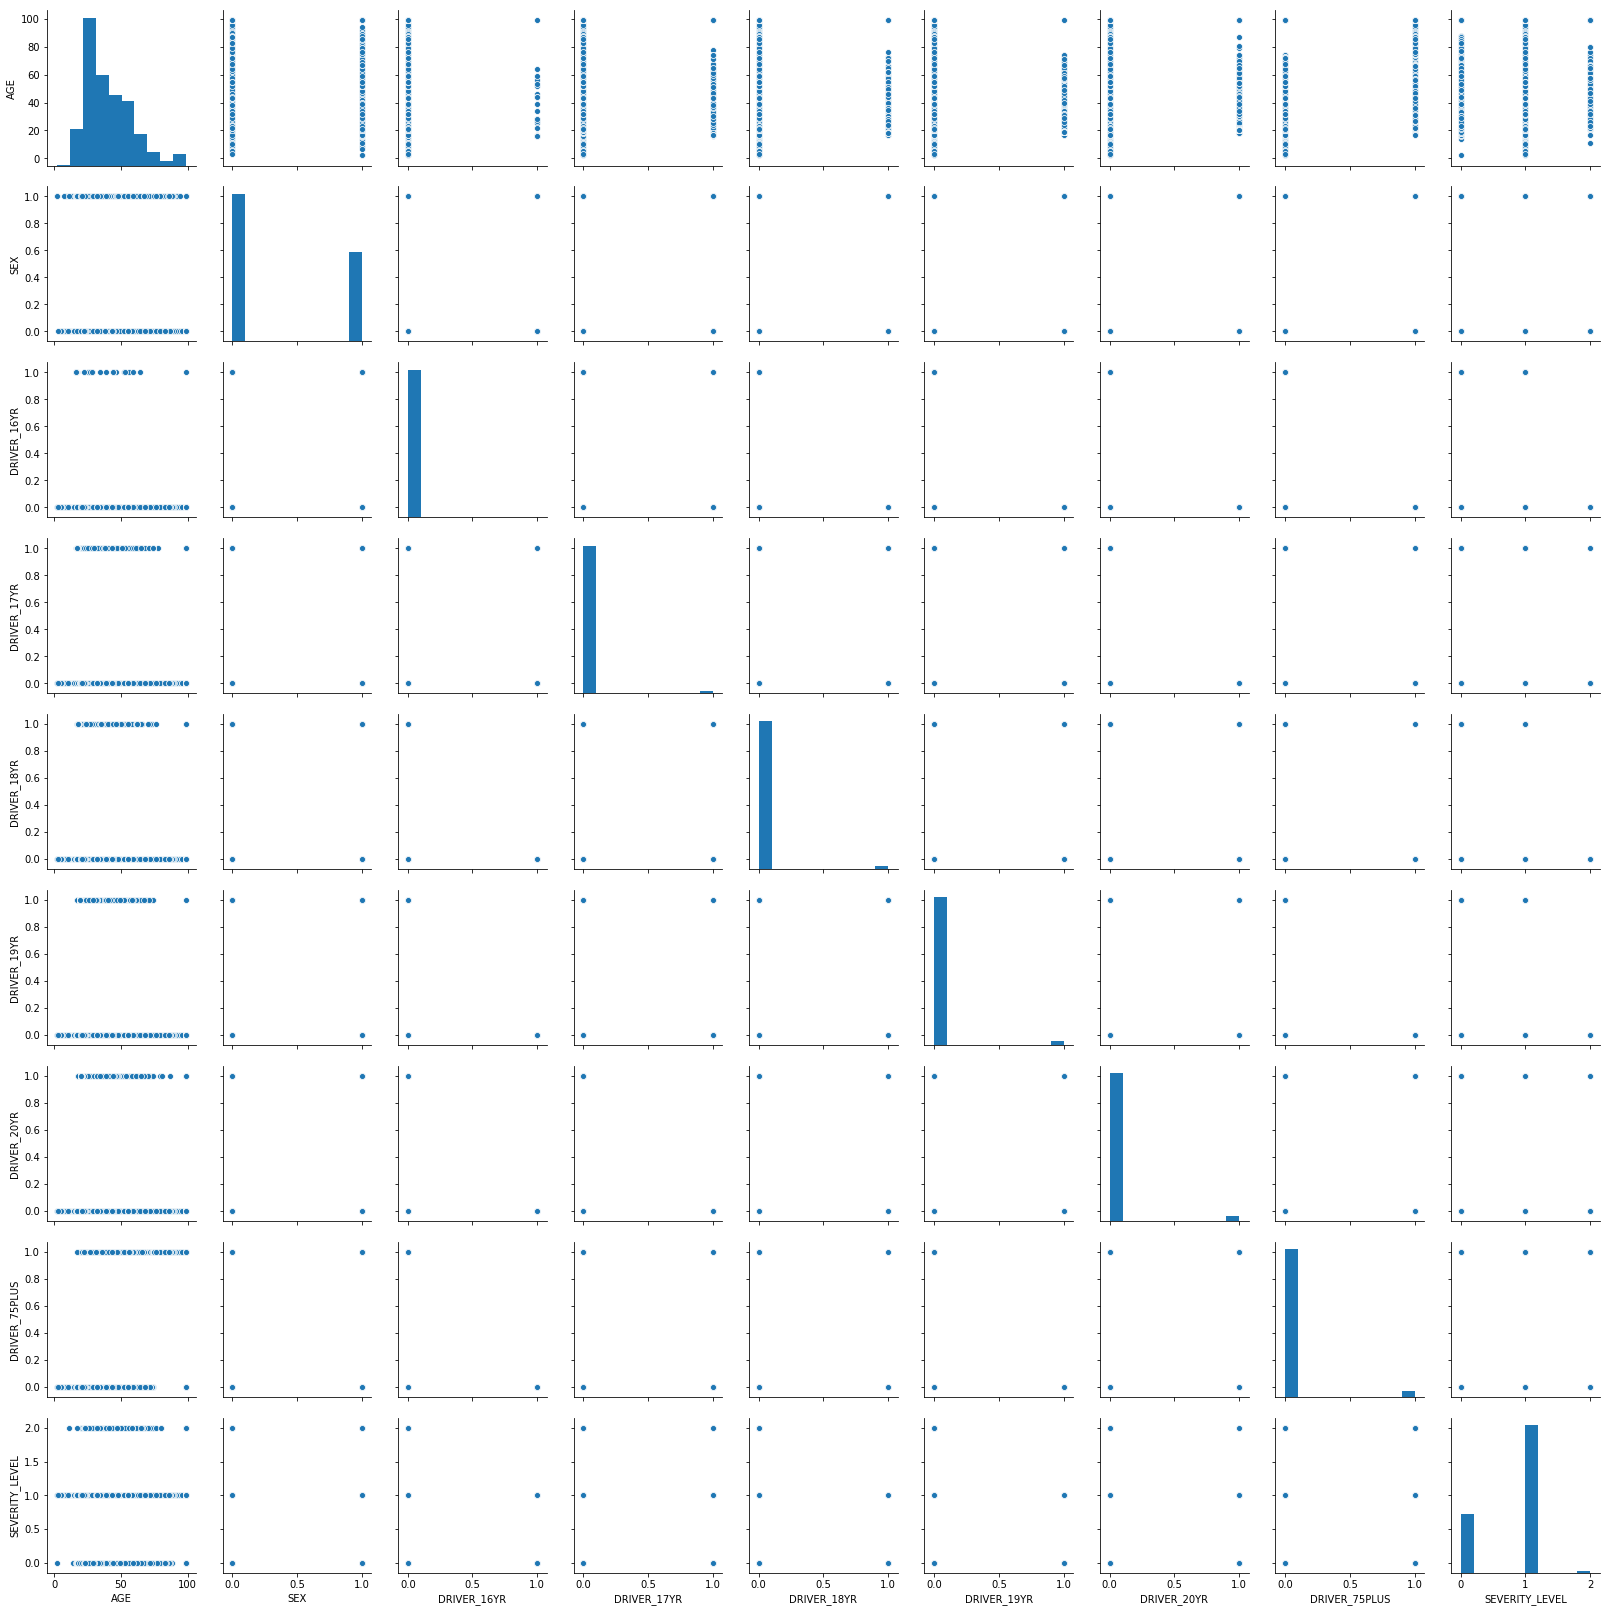

In [139]:
pairplot(df_r3)

In [140]:
corr3 = df_r3[:-1].corr()

In [141]:
corr3

,AGE,SEX,DRIVER_16YR,DRIVER_17YR,DRIVER_18YR,DRIVER_19YR,DRIVER_20YR,DRIVER_75PLUS,SEVERITY_LEVEL
AGE,1.000000,-0.067439,-0.033751,-0.068266,-0.088337,-0.111553,-0.113534,0.241815,0.090709
SEX,-0.067439,1.000000,0.012444,0.002566,0.019403,0.006939,0.004746,0.016213,0.033954
DRIVER_16YR,-0.033751,0.012444,1.000000,0.017099,-0.007256,-0.008697,-0.009338,-0.009800,0.006815
DRIVER_17YR,-0.068266,0.002566,0.017099,1.000000,0.002439,-0.013815,-0.021860,-0.017087,-0.014918
DRIVER_18YR,-0.088337,0.019403,-0.007256,0.002439,1.000000,-0.013073,-0.003736,-0.024664,-0.018533
DRIVER_19YR,-0.111553,0.006939,-0.008697,-0.013815,-0.013073,1.000000,-0.025308,-0.035103,-0.022213
DRIVER_20YR,-0.113534,0.004746,-0.009338,-0.021860,-0.003736,-0.025308,1.000000,-0.026766,-0.028098
DRIVER_75PLUS,0.241815,0.016213,-0.009800,-0.017087,-0.024664,-0.035103,-0.026766,1.000000,0.030864
SEVERITY_LEVEL,0.090709,0.033954,0.006815,-0.014918,-0.018533,-0.022213,-0.028098,0.030864,1.000000


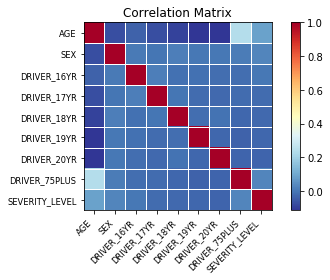

In [142]:
fig3=plot_corr(corr3,xnames=corr3.columns)

### 5. Deployment and Conclusion

Now that three models have been built and evaluated, we can choose which model is appropriate to answer the business question. All three models had identical predictive accuracy scores, so I will focus on the statistical measures to choose a model. Model #1 suffered from Multicollinearity, in which some of the predictors were correlated with each other, so it is not a good model for this problem. Model #2 and Model #3 are both statistically valid, but #2 contained irrelevant predictors that I eliminated in #3. So my analysis will focus on the results from Model #3. None of these models had very high r^2 scores, but we got enough information from the regression summaries to answer the question at hand. According to both models #2 and #3, AGE and SEX are both statistically significant in crashes where people were injured or killed. Therefore, it is reasonable for both to be used by insurance companies to classify car insurance customers into risk &mdash; and therefore price &mdash; categories.